In [1]:
import tensorflow as tf
import os
import zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Model

# Set mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Suppress TensorFlow logging except errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Disable OneDNN Optimizations
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.17.0
Num GPUs Available:  1


# Dataset

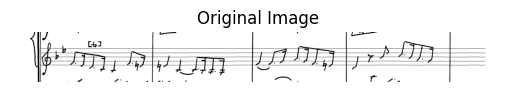

In [2]:
# Data Extraction
def extract_data(zip_file_path, extraction_dir):
    if not os.path.exists(extraction_dir):
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_dir)
    image_dir = os.path.join(extraction_dir, 'muscima_pp_cropped_images_with_stafflines')
    image_paths = list(Path(image_dir).iterdir())
    return image_dir, image_paths

# Corrected line to call extract_data
image_dir, image_paths = extract_data('/content/muscima_pp_cropped_images_with_stafflines.zip', 'Musicma_dataset')

# Display a sample image (Original Image)
sample_image_path = os.path.join(image_dir, 'CVC-MUSCIMA_W-07_N-05_D-ideal_2.png')
sample_image = tf.io.read_file(sample_image_path)
sample_image = tf.image.decode_png(sample_image)
sample_image = tf.image.convert_image_dtype(sample_image, tf.float32)

plt.figure()
plt.imshow(tf.squeeze(sample_image), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Data preparation

In [3]:
# Preprocess Image Functions with Data Augmentation
def enhance_contrast(image):
    return tf.image.adjust_contrast(image, 1.2)  # Slight contrast enhancement

def add_gaussian_noise(image, stddev=0.01):  # Reduced standard deviation for less noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=stddev, dtype=tf.float32)
    return tf.clip_by_value(image + noise, 0.0, 1.0)

# Slicing and combining image

In [4]:
def slice_image_fixed(image, num_slices_h=1, num_slices_w=2, target_slice_size=(256, 256)):
    height, width = tf.shape(image)[0], tf.shape(image)[1]
    slice_height = height // num_slices_h
    slice_width = width // num_slices_w
    slices = []

    for i in range(num_slices_h):
        for j in range(num_slices_w):
            y_start = i * slice_height
            x_start = j * slice_width
            y_end = tf.minimum(y_start + slice_height, height)
            x_end = tf.minimum(x_start + slice_width, width)
            slice_ = image[y_start:y_end, x_start:x_end, :]
            slice_ = tf.image.resize(slice_, target_slice_size)
            slice_ = tf.image.rgb_to_grayscale(slice_)
            slices.append(slice_)

    return tf.stack(slices)

In [5]:
def combine_slices(slices, target_height=256, target_width=512, slice_size=(256, 256), overlap=(4, 4)):  # Increased target size back to 256
    full_image = np.zeros((target_height, target_width, 1), dtype=np.float32)
    overlap_count = np.zeros((target_height, target_width, 1), dtype=np.float32)
    slice_idx = 0

    for y in range(0, target_height, slice_size[0] - overlap[0]):
        for x in range(0, target_width, slice_size[1] - overlap[1]):
            if slice_idx >= len(slices):
                break
            slice_ = slices[slice_idx]

            if len(slice_.shape) == 2:
                slice_height, slice_width = slice_.shape
                slice_ = np.expand_dims(slice_, axis=-1)
            else:
                slice_height, slice_width, _ = slice_.shape

            if y + slice_height <= target_height and x + slice_width <= target_width:
                full_image[y:y + slice_height, x:x + slice_width, :] += slice_
                overlap_count[y:y + slice_height, x:x + slice_width, :] += 1

            slice_idx += 1

        if slice_idx >= len(slices):
            break

    # Prevent division by zero in areas with no overlap
    overlap_count[overlap_count == 0] = 1
    full_image /= overlap_count  # Average the overlapping areas

    full_image_resized = tf.image.resize(full_image, (256, 512))  # Adjusted resize back to 256
    return tf.convert_to_tensor(full_image_resized)

In [6]:
def preprocess_image_slices(image, training=True):
    slices = slice_image_fixed(image, num_slices_h=1, num_slices_w=2, target_slice_size=(256, 256))
    slices = enhance_contrast(slices)
    if training:
        slices = add_gaussian_noise(slices)
    return slices

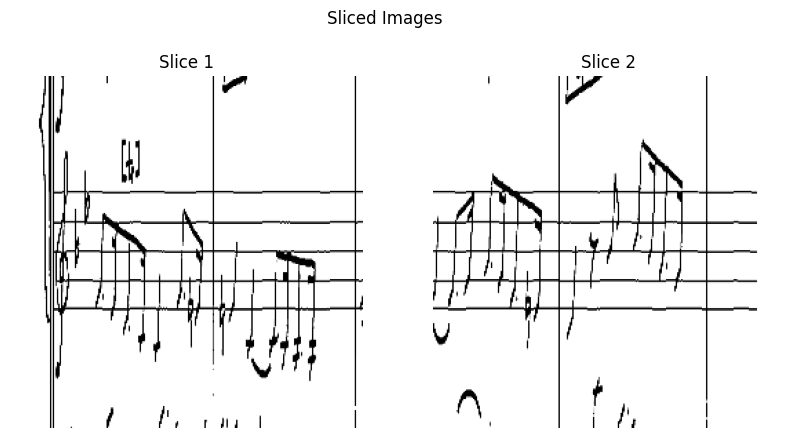

In [7]:
# Preprocess the sample image and display slices
sliced_images = preprocess_image_slices(sample_image, training=False)
plt.figure(figsize=(10, 5))
for i in range(sliced_images.shape[0]):
    plt.subplot(1, sliced_images.shape[0], i+1)
    plt.imshow(tf.squeeze(sliced_images[i]), cmap='gray')
    plt.title(f'Slice {i+1}')
    plt.axis('off')
plt.suptitle('Sliced Images')
plt.show()

In [8]:
@tf.function
def load_and_preprocess_image(image_path, training=True):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Apply data augmentation
    if training:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_contrast(image, 0.5, 2.0)
        image = tf.image.random_brightness(image, max_delta=0.1)  # Adding random brightness change

    return preprocess_image_slices(image, training=training)

In [9]:
def create_dataset(image_dir, batch_size=4, training=True):
    image_paths = sorted([str(p) for p in Path(image_dir).iterdir() if p.suffix in ['.png', '.jpg', '.jpeg']])
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(lambda x: load_and_preprocess_image(x, training=training), num_parallel_calls=tf.data.AUTOTUNE)

    # Cache after loading and preprocessing
    if training:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.unbatch()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [10]:
# Reducing batch size to 4
handwritten_dataset = create_dataset(image_dir, batch_size=4, training=True)

In [11]:
for step, input_images in enumerate(handwritten_dataset.take(1)):  # Take one batch for inspection
    print("Shape of input_images from dataset:", input_images.shape)


Shape of input_images from dataset: (4, 256, 256, 1)


# ESGAN MODEL

In [12]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [13]:
# Simplified Generator without Latent Vector
def esrgan_generator():
    image_input = tf.keras.layers.Input(shape=[256, 256, 1])  # Adjusted input size

    # Initial convolution block
    x = tf.keras.layers.Conv2D(32, kernel_size=9, strides=1, padding='same', kernel_initializer=initializer)(image_input)
    x = tf.keras.layers.PReLU()(x)

    # Residual blocks
    for _ in range(4):  # Reduced to 4 residual blocks
        skip = x
        x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', kernel_initializer=initializer)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.PReLU()(x)
        x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', kernel_initializer=initializer)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.add([skip, x])

    # Final layers
    x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.PReLU()(x)
    outputs = tf.keras.layers.Conv2D(1, kernel_size=9, strides=1, padding='same', activation='tanh', kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=image_input, outputs=outputs)

In [14]:
# Increased Dropout in the Discriminator
def esrgan_discriminator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 2])  # Adjusted input size
    x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', kernel_initializer=initializer)(inputs)  # Reduced filters
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Increased dropout

    x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_initializer=initializer)(x)  # Reduced filters
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)

    x = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer=initializer)(x)  # Reduced filters
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Increased dropout

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, kernel_initializer=initializer)(x)  # Reduced units
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [15]:
generator = esrgan_generator()
discriminator = esrgan_discriminator()

# Loss Function

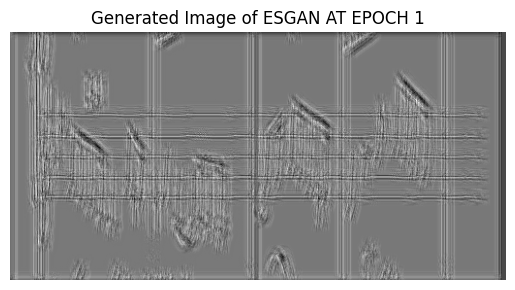

In [16]:
generated_slices = []
for slice_ in sliced_images:
    resized_slice = tf.image.resize(slice_, (256, 256))
    resized_slice = tf.expand_dims(resized_slice, -1)
    generated_slice = generator(tf.expand_dims(resized_slice, 0), training=False)
    generated_slices.append(generated_slice[0])

combined_image_before_training = combine_slices(generated_slices, target_height=256, target_width=512, slice_size=(256, 256))

plt.figure()
plt.imshow(tf.squeeze(combined_image_before_training), cmap='gray')
plt.title('Generated Image of ESGAN AT EPOCH 1')
plt.axis('off')
plt.show()

In [17]:
# Adjusted ESRGAN Generator Loss Function
esrgan_loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def esrgan_generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.cast(esrgan_loss_object(tf.ones_like(disc_generated_output), disc_generated_output), tf.float32)
    l1_loss = tf.cast(tf.reduce_mean(tf.abs(target - gen_output)), tf.float32)

    # Further reduced emphasis on L1 loss to allow adversarial training to have more impact
    total_gen_loss = gan_loss + 25 * l1_loss
    return total_gen_loss

# Adjusted Label Smoothing
def esrgan_discriminator_loss(real, generated):
    # Less aggressive label smoothing
    real_loss = esrgan_loss_object(tf.ones_like(real) * 0.95, real)
    generated_loss = esrgan_loss_object(tf.zeros_like(generated), generated)
    return real_loss + generated_loss

In [18]:
# Further reduced learning rate for the generator to stabilize its updates
esrgan_generator_optimizer = tf.keras.optimizers.Adam(5e-5, beta_1=0.5)
esrgan_discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)

In [19]:
@tf.function
def esrgan_train_step(input_image, target):
    input_image_resized = tf.image.resize(input_image, (256, 256))  # Adjusted size
    target_resized = tf.image.resize(target, (256, 256))  # Adjusted size

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image_resized, training=True)
        gen_output = tf.cast(gen_output, dtype=tf.float32)

        combined_real = tf.concat([input_image_resized, target_resized], axis=-1)
        combined_fake = tf.concat([input_image_resized, gen_output], axis=-1)

        disc_real_output = discriminator(combined_real, training=True)
        disc_generated_output = discriminator(combined_fake, training=True)

        gen_loss = esrgan_generator_loss(disc_generated_output, gen_output, target_resized)
        disc_loss = esrgan_discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    esrgan_generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    esrgan_discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [20]:
# Updated training loop to collect losses and ensure different images are used in each epoch
def fit_esrgan(dataset, epochs):
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        print(f"Starting epoch {epoch+1}")
        start = time.time()
        last_gen_loss = None
        last_disc_loss = None

        # Shuffle the dataset at the beginning of each epoch
        dataset = dataset.shuffle(buffer_size=len(image_paths))

        for step, input_image in enumerate(dataset):
            target = input_image
            gen_loss, disc_loss = esrgan_train_step(input_image, target)
            last_gen_loss = gen_loss
            last_disc_loss = disc_loss

        # Save the losses for this epoch
        gen_losses.append(last_gen_loss)
        disc_losses.append(last_disc_loss)

        print(f"Last Step: Gen Loss: {last_gen_loss}, Disc Loss: {last_disc_loss}")
        print(f"Epoch {epoch+1} completed in {time.time()-start:.2f} sec")

        # Load a new random image from the dataset for visualization
        random_image_path = np.random.choice(image_paths)
        random_image = tf.io.read_file(str(random_image_path))
        random_image = tf.image.decode_png(random_image)
        random_image = tf.image.convert_image_dtype(random_image, tf.float32)
        sliced_images = preprocess_image_slices(random_image, training=False)

        # Display the generated image after each epoch
        generated_slices = []
        for slice_ in sliced_images:
            resized_slice = tf.image.resize(slice_, (256, 256))  # Adjusted size
            resized_slice = tf.expand_dims(resized_slice, -1)
            generated_slice = generator(tf.expand_dims(resized_slice, 0), training=False)
            generated_slices.append(generated_slice[0])

        combined_image_after_training = combine_slices(generated_slices, target_height=256, target_width=512, slice_size=(256, 256))  # Adjusted size

        plt.figure()
        plt.imshow(tf.squeeze(combined_image_after_training), cmap='gray')
        plt.title(f'Generated Image After Epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    return gen_losses, disc_losses

Training ESRGAN
Starting epoch 1
Last Step: Gen Loss: 1.915771484375, Disc Loss: 2.8913121223449707
Epoch 1 completed in 39.85 sec


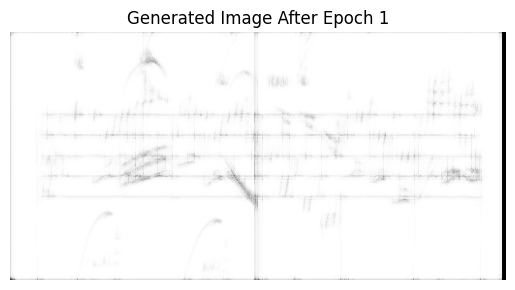

Starting epoch 2
Last Step: Gen Loss: 1.2384227514266968, Disc Loss: 2.32684326171875
Epoch 2 completed in 18.74 sec


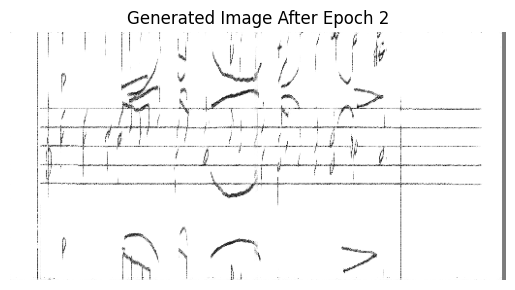

Starting epoch 3
Last Step: Gen Loss: 1.1953462362289429, Disc Loss: 1.7778321504592896
Epoch 3 completed in 18.76 sec


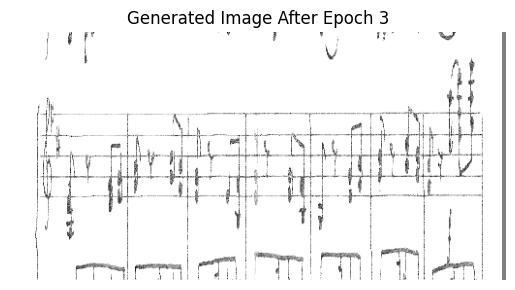

Starting epoch 4
Last Step: Gen Loss: 1.318650722503662, Disc Loss: 1.5023263692855835
Epoch 4 completed in 18.73 sec


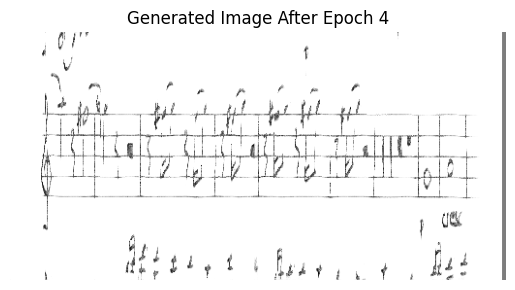

Starting epoch 5
Last Step: Gen Loss: 0.9033560752868652, Disc Loss: 1.815479040145874
Epoch 5 completed in 18.73 sec


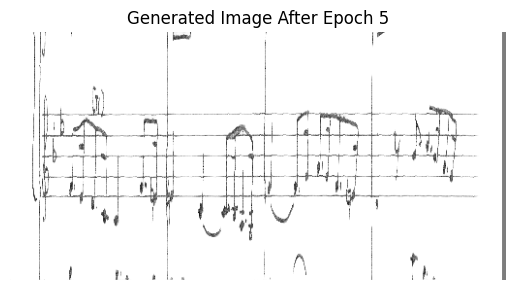

Starting epoch 6
Last Step: Gen Loss: 1.042122721672058, Disc Loss: 1.52645742893219
Epoch 6 completed in 18.73 sec


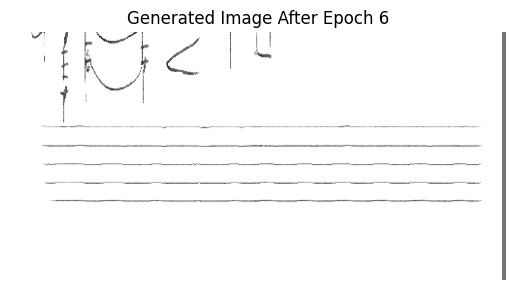

Starting epoch 7
Last Step: Gen Loss: 1.2592480182647705, Disc Loss: 1.784292459487915
Epoch 7 completed in 18.77 sec


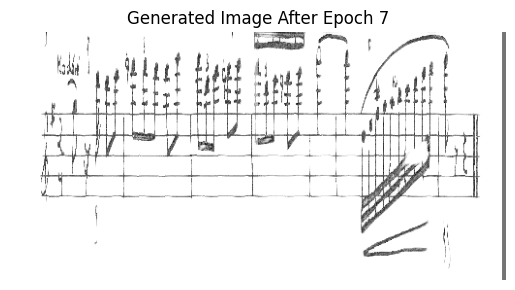

Starting epoch 8
Last Step: Gen Loss: 1.1812363862991333, Disc Loss: 1.6761529445648193
Epoch 8 completed in 18.73 sec


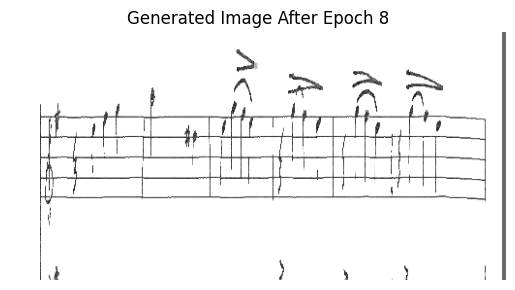

Starting epoch 9
Last Step: Gen Loss: 1.11725914478302, Disc Loss: 1.7773232460021973
Epoch 9 completed in 18.73 sec


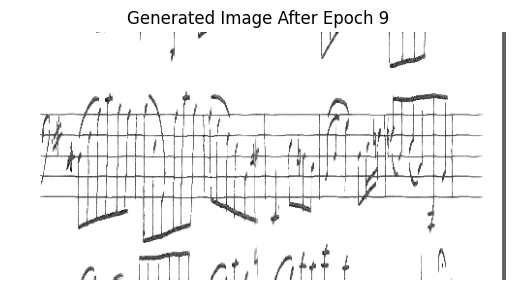

Starting epoch 10
Last Step: Gen Loss: 1.2203158140182495, Disc Loss: 1.4260337352752686
Epoch 10 completed in 18.76 sec


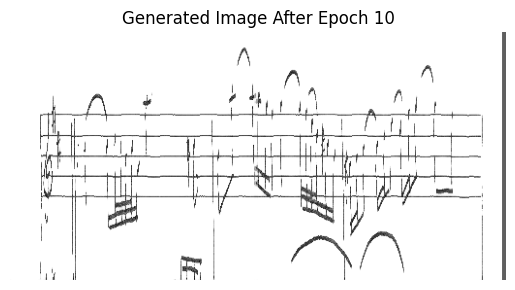

Starting epoch 11
Last Step: Gen Loss: 1.106091856956482, Disc Loss: 1.3828965425491333
Epoch 11 completed in 18.73 sec


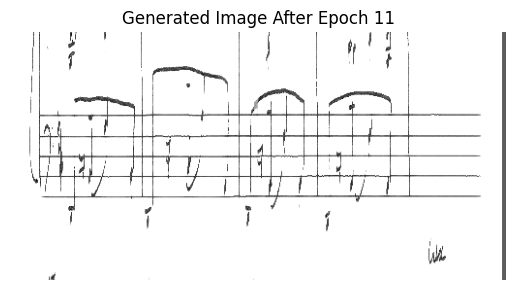

Starting epoch 12
Last Step: Gen Loss: 1.946286678314209, Disc Loss: 1.2835776805877686
Epoch 12 completed in 18.73 sec


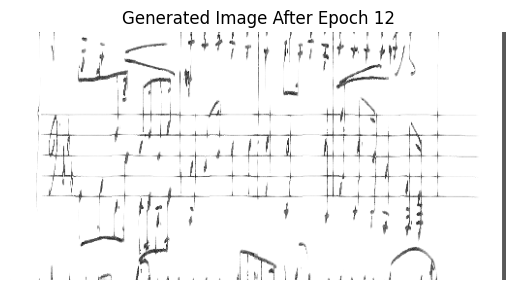

Starting epoch 13
Last Step: Gen Loss: 1.216808557510376, Disc Loss: 1.388145923614502
Epoch 13 completed in 18.78 sec


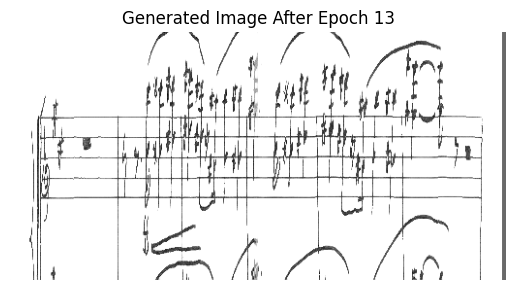

Starting epoch 14
Last Step: Gen Loss: 1.320288896560669, Disc Loss: 1.460355520248413
Epoch 14 completed in 18.73 sec


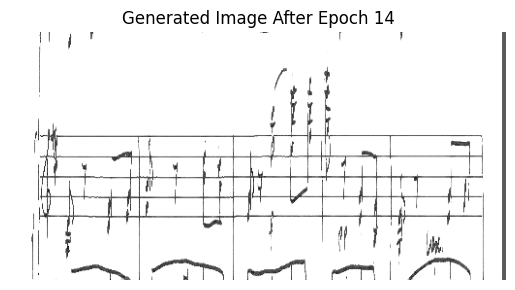

Starting epoch 15
Last Step: Gen Loss: 0.7437211275100708, Disc Loss: 1.5352321863174438
Epoch 15 completed in 18.74 sec


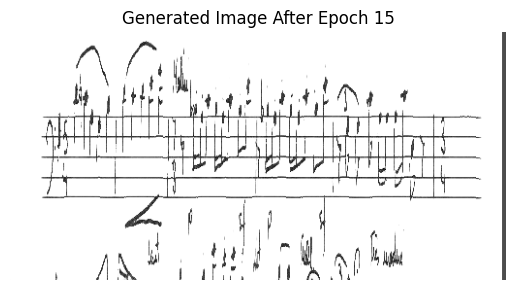

Starting epoch 16
Last Step: Gen Loss: 0.8232893347740173, Disc Loss: 1.6243693828582764
Epoch 16 completed in 18.77 sec


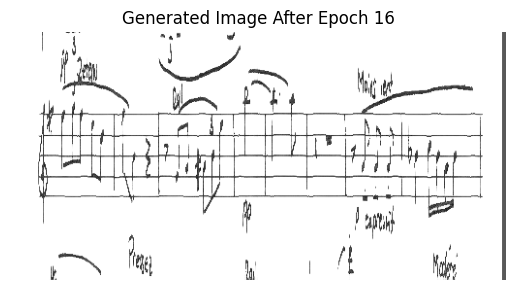

Starting epoch 17
Last Step: Gen Loss: 1.0192922353744507, Disc Loss: 1.448955774307251
Epoch 17 completed in 18.74 sec


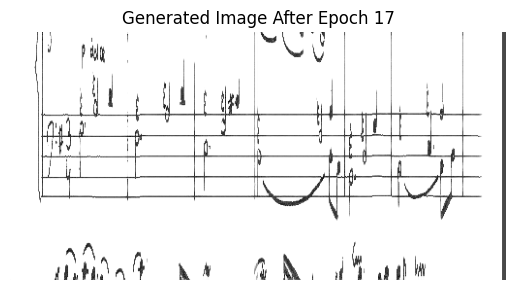

Starting epoch 18
Last Step: Gen Loss: 1.3440093994140625, Disc Loss: 1.3705241680145264
Epoch 18 completed in 18.74 sec


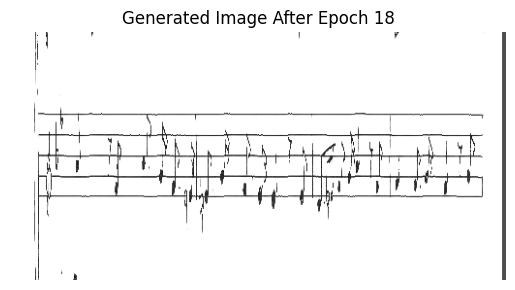

Starting epoch 19
Last Step: Gen Loss: 1.023815631866455, Disc Loss: 1.4483318328857422
Epoch 19 completed in 18.73 sec


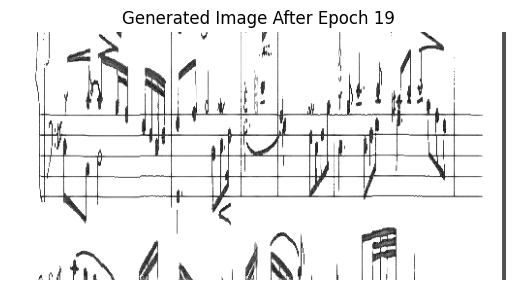

Starting epoch 20
Last Step: Gen Loss: 1.0445419549942017, Disc Loss: 1.3037445545196533
Epoch 20 completed in 18.78 sec


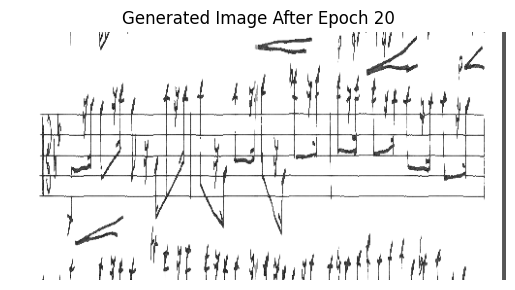

Starting epoch 21
Last Step: Gen Loss: 0.8493393659591675, Disc Loss: 1.706479549407959
Epoch 21 completed in 18.75 sec


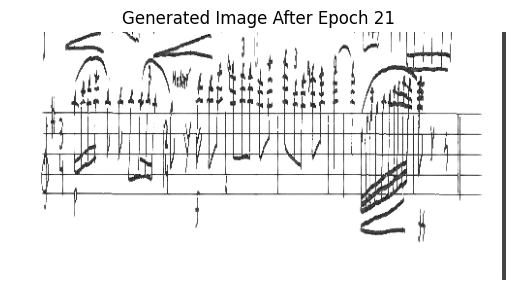

Starting epoch 22
Last Step: Gen Loss: 0.9775944352149963, Disc Loss: 1.435072898864746
Epoch 22 completed in 18.74 sec


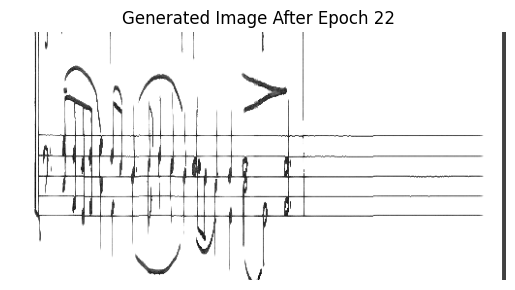

Starting epoch 23
Last Step: Gen Loss: 0.7699511647224426, Disc Loss: 1.6242547035217285
Epoch 23 completed in 18.80 sec


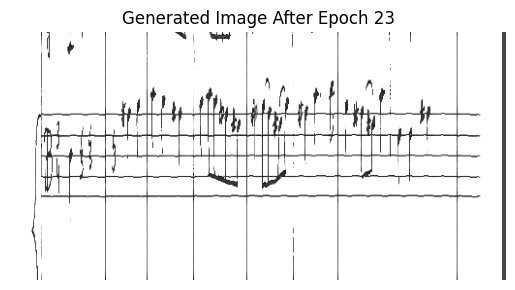

Starting epoch 24
Last Step: Gen Loss: 1.1578576564788818, Disc Loss: 1.1559027433395386
Epoch 24 completed in 18.75 sec


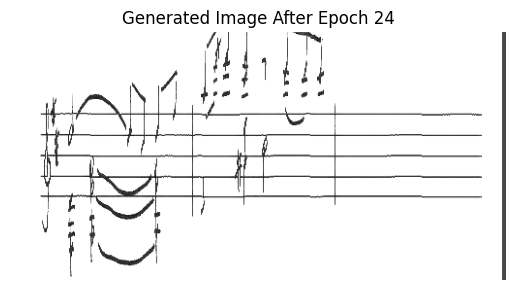

Starting epoch 25
Last Step: Gen Loss: 0.974223256111145, Disc Loss: 1.481080174446106
Epoch 25 completed in 18.74 sec


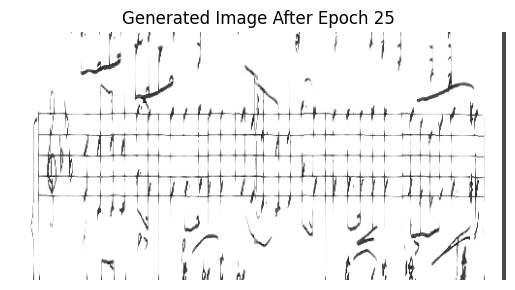

Starting epoch 26
Last Step: Gen Loss: 1.068178653717041, Disc Loss: 1.4480032920837402
Epoch 26 completed in 18.77 sec


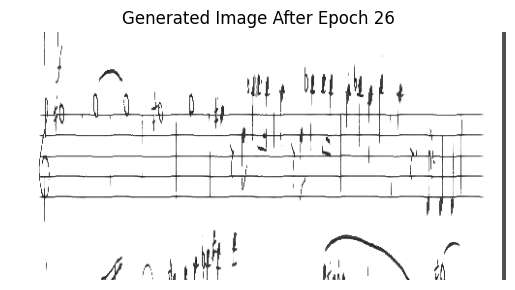

Starting epoch 27
Last Step: Gen Loss: 0.8842374086380005, Disc Loss: 1.4094024896621704
Epoch 27 completed in 18.75 sec


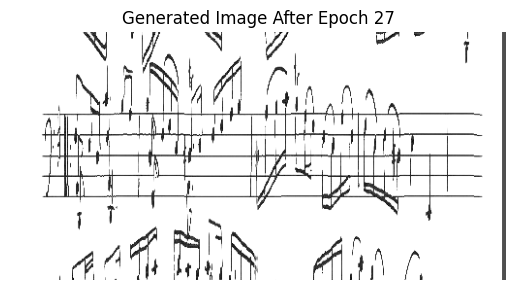

Starting epoch 28
Last Step: Gen Loss: 0.9116805791854858, Disc Loss: 1.3239413499832153
Epoch 28 completed in 18.74 sec


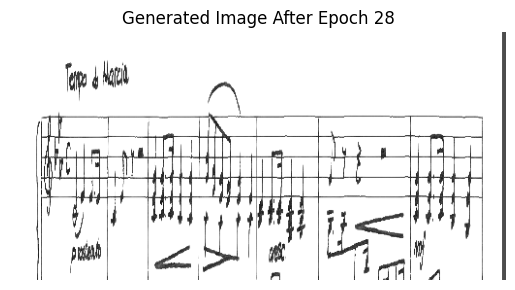

Starting epoch 29
Last Step: Gen Loss: 1.1616336107254028, Disc Loss: 1.3995753526687622
Epoch 29 completed in 18.77 sec


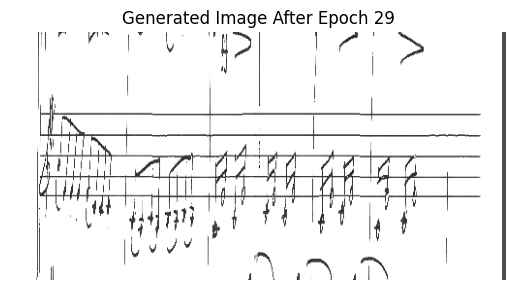

Starting epoch 30
Last Step: Gen Loss: 2.188328981399536, Disc Loss: 1.3095381259918213
Epoch 30 completed in 18.75 sec


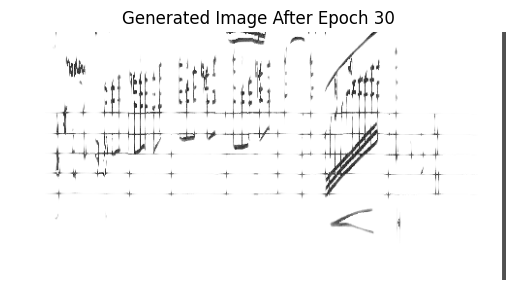

Starting epoch 31
Last Step: Gen Loss: 1.2408664226531982, Disc Loss: 1.1918292045593262
Epoch 31 completed in 18.74 sec


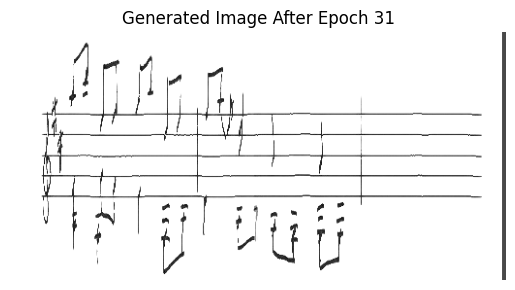

Starting epoch 32
Last Step: Gen Loss: 0.8084975481033325, Disc Loss: 1.4702636003494263
Epoch 32 completed in 18.74 sec


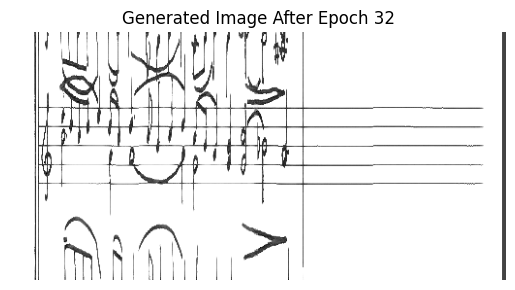

Starting epoch 33
Last Step: Gen Loss: 0.7094078660011292, Disc Loss: 1.4541950225830078
Epoch 33 completed in 18.78 sec


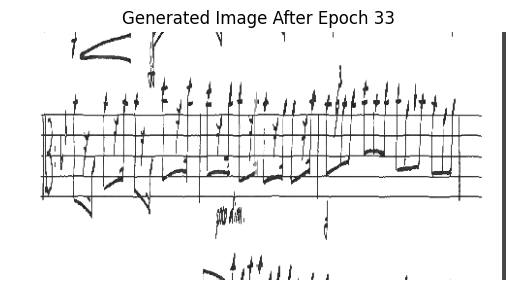

Starting epoch 34
Last Step: Gen Loss: 0.8809247612953186, Disc Loss: 1.3689066171646118
Epoch 34 completed in 18.74 sec


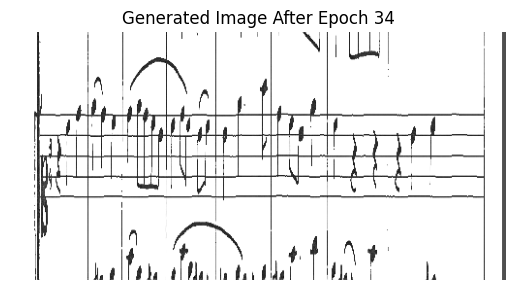

Starting epoch 35
Last Step: Gen Loss: 0.8451276421546936, Disc Loss: 1.3625715970993042
Epoch 35 completed in 18.74 sec


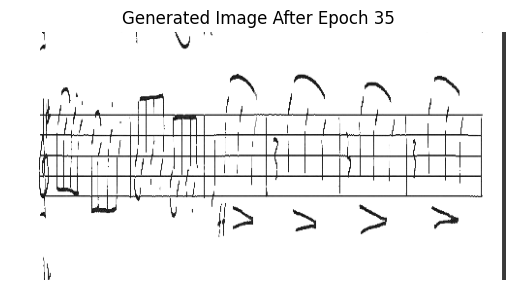

Starting epoch 36
Last Step: Gen Loss: 1.0490574836730957, Disc Loss: 1.6233160495758057
Epoch 36 completed in 18.78 sec


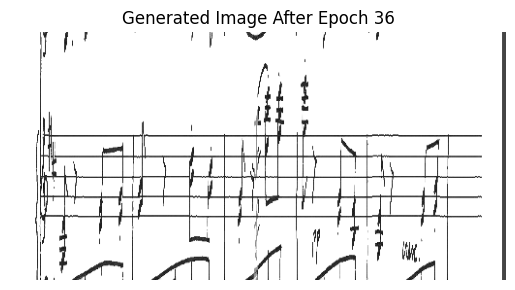

Starting epoch 37
Last Step: Gen Loss: 1.041184425354004, Disc Loss: 1.220354437828064
Epoch 37 completed in 18.75 sec


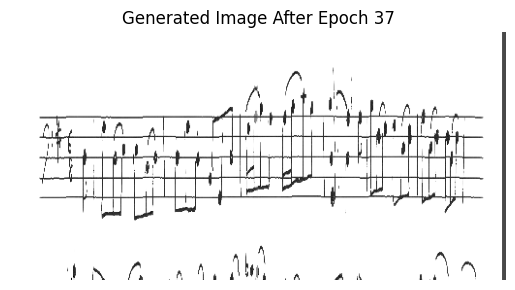

Starting epoch 38
Last Step: Gen Loss: 1.6978919506072998, Disc Loss: 1.4463222026824951
Epoch 38 completed in 18.74 sec


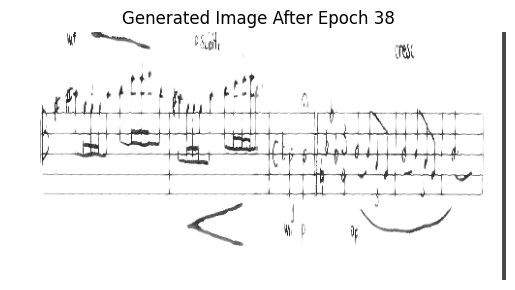

Starting epoch 39
Last Step: Gen Loss: 0.9725509881973267, Disc Loss: 1.3594392538070679
Epoch 39 completed in 18.81 sec


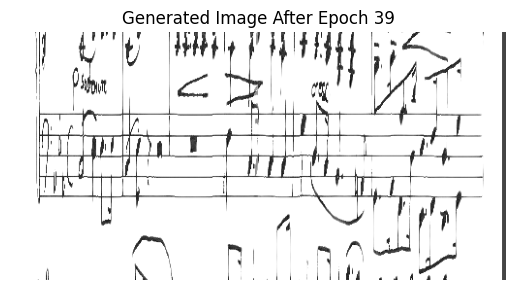

Starting epoch 40
Last Step: Gen Loss: 0.9856066107749939, Disc Loss: 1.2782261371612549
Epoch 40 completed in 18.76 sec


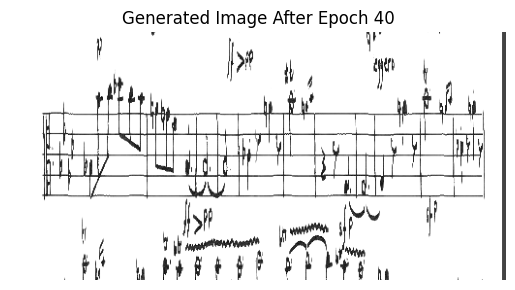

Starting epoch 41
Last Step: Gen Loss: 0.9751516580581665, Disc Loss: 1.4663925170898438
Epoch 41 completed in 18.75 sec


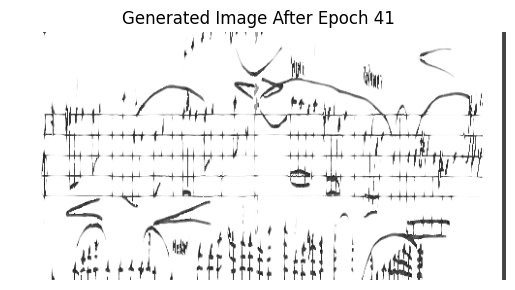

Starting epoch 42
Last Step: Gen Loss: 0.8008003234863281, Disc Loss: 1.4806041717529297
Epoch 42 completed in 18.78 sec


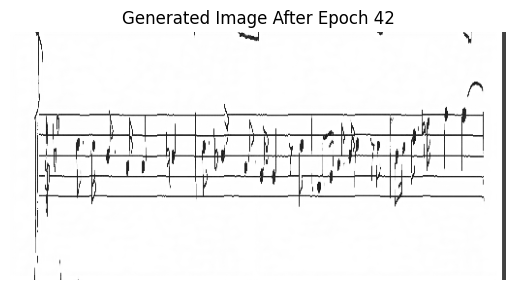

Starting epoch 43
Last Step: Gen Loss: 0.8497476577758789, Disc Loss: 1.511979103088379
Epoch 43 completed in 18.76 sec


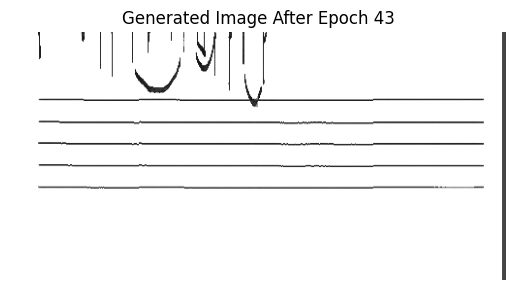

Starting epoch 44
Last Step: Gen Loss: 0.7980403900146484, Disc Loss: 1.5164289474487305
Epoch 44 completed in 18.75 sec


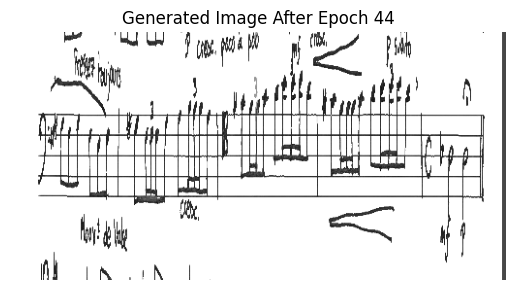

Starting epoch 45
Last Step: Gen Loss: 0.7632559537887573, Disc Loss: 1.493253469467163
Epoch 45 completed in 18.76 sec


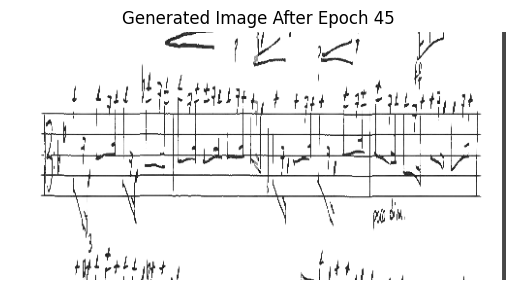

Starting epoch 46
Last Step: Gen Loss: 0.9628705978393555, Disc Loss: 1.370473861694336
Epoch 46 completed in 18.80 sec


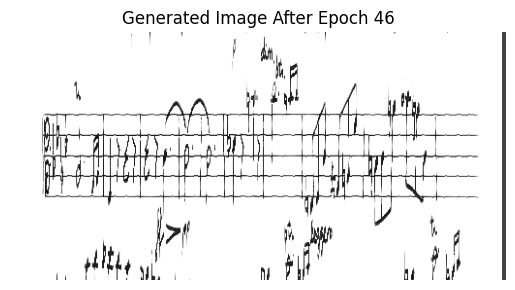

Starting epoch 47
Last Step: Gen Loss: 0.8599241375923157, Disc Loss: 1.4826284646987915
Epoch 47 completed in 18.75 sec


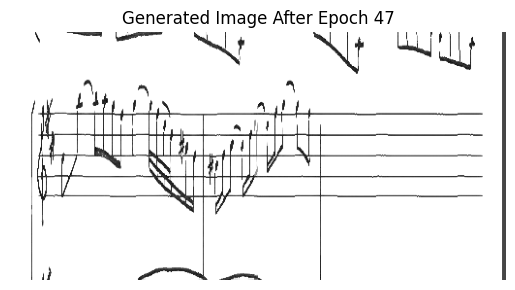

Starting epoch 48
Last Step: Gen Loss: 0.9728203415870667, Disc Loss: 1.362274169921875
Epoch 48 completed in 18.75 sec


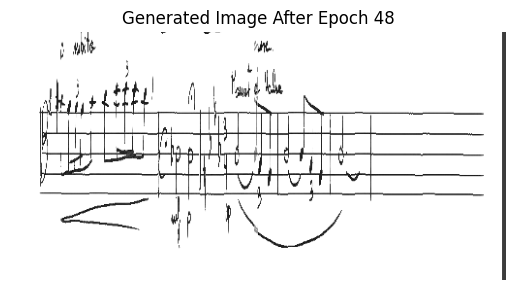

Starting epoch 49
Last Step: Gen Loss: 0.7932072877883911, Disc Loss: 1.3861339092254639
Epoch 49 completed in 18.79 sec


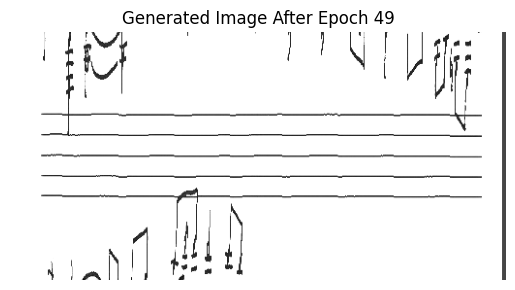

Starting epoch 50
Last Step: Gen Loss: 1.0313585996627808, Disc Loss: 1.2861777544021606
Epoch 50 completed in 18.75 sec


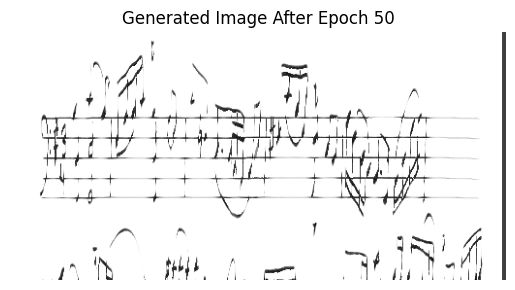

Starting epoch 51
Last Step: Gen Loss: 0.7234376668930054, Disc Loss: 1.5578526258468628
Epoch 51 completed in 18.76 sec


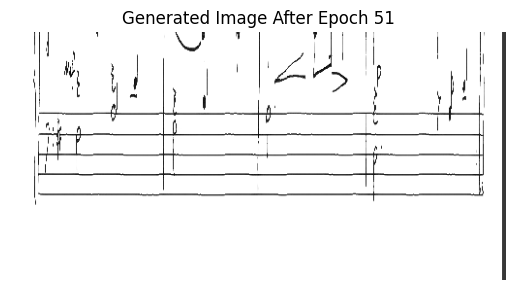

Starting epoch 52
Last Step: Gen Loss: 0.9526796340942383, Disc Loss: 1.4554622173309326
Epoch 52 completed in 18.78 sec


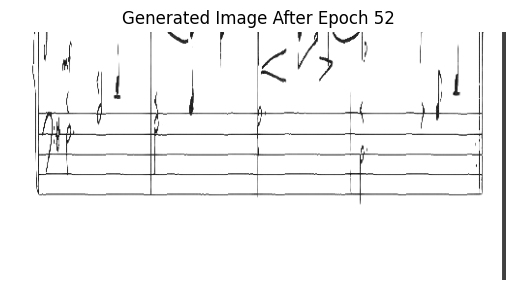

Starting epoch 53
Last Step: Gen Loss: 1.7259862422943115, Disc Loss: 1.5057101249694824
Epoch 53 completed in 18.76 sec


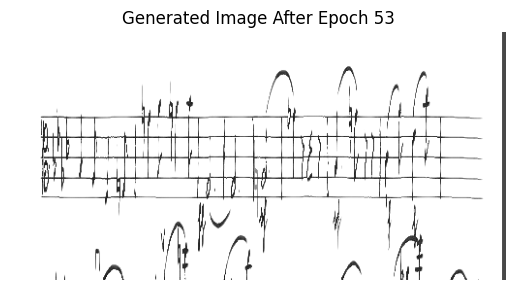

Starting epoch 54
Last Step: Gen Loss: 0.7934011220932007, Disc Loss: 1.540323257446289
Epoch 54 completed in 18.84 sec


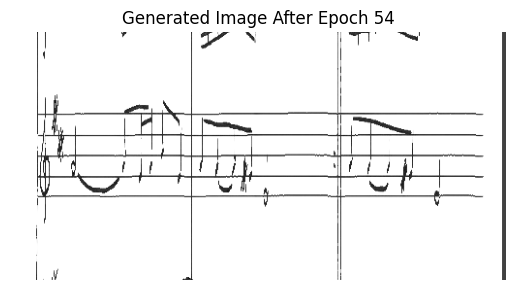

Starting epoch 55
Last Step: Gen Loss: 0.7346256375312805, Disc Loss: 1.4607566595077515
Epoch 55 completed in 18.79 sec


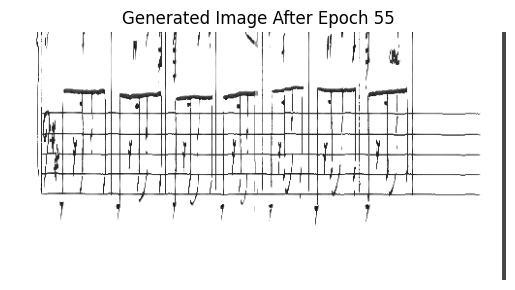

Starting epoch 56
Last Step: Gen Loss: 1.3333392143249512, Disc Loss: 1.335767388343811
Epoch 56 completed in 18.77 sec


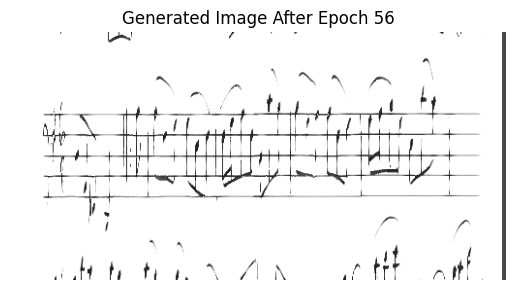

Starting epoch 57
Last Step: Gen Loss: 0.7731829881668091, Disc Loss: 1.4920654296875
Epoch 57 completed in 18.75 sec


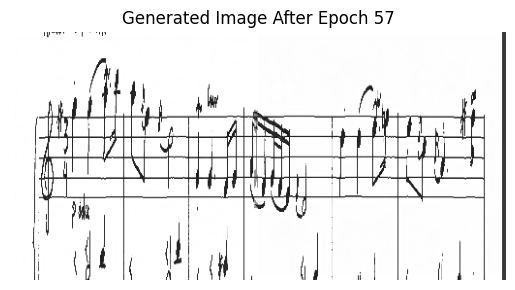

Starting epoch 58
Last Step: Gen Loss: 0.9397573471069336, Disc Loss: 1.542151689529419
Epoch 58 completed in 18.75 sec


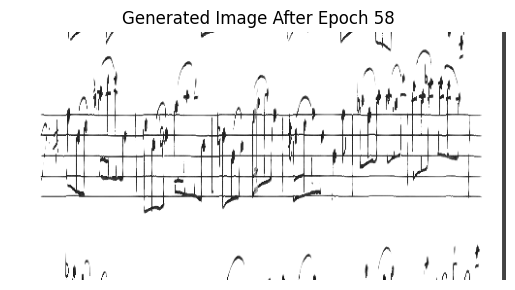

Starting epoch 59
Last Step: Gen Loss: 0.80930095911026, Disc Loss: 1.426976203918457
Epoch 59 completed in 18.75 sec


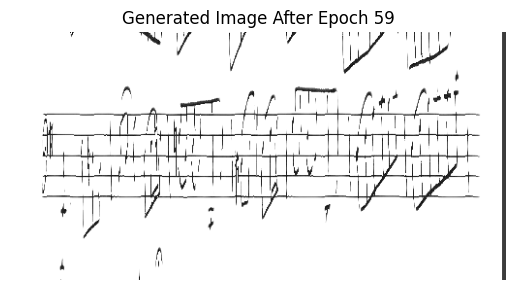

Starting epoch 60
Last Step: Gen Loss: 0.9097963571548462, Disc Loss: 1.4127284288406372
Epoch 60 completed in 18.76 sec


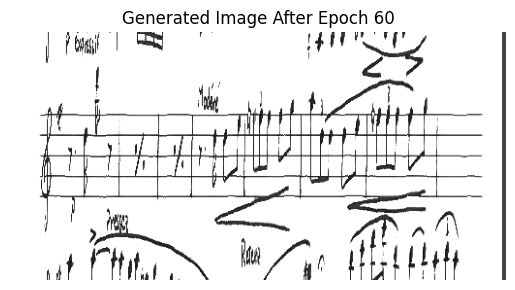

Starting epoch 61
Last Step: Gen Loss: 0.8525952696800232, Disc Loss: 1.3854076862335205
Epoch 61 completed in 18.77 sec


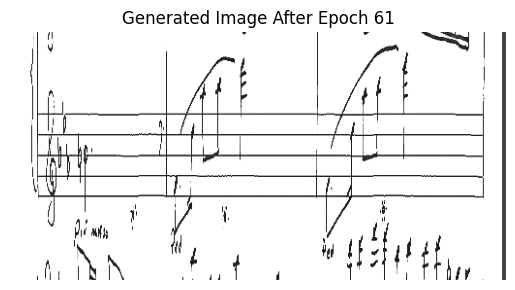

Starting epoch 62
Last Step: Gen Loss: 0.7868397235870361, Disc Loss: 1.3862007856369019
Epoch 62 completed in 18.80 sec


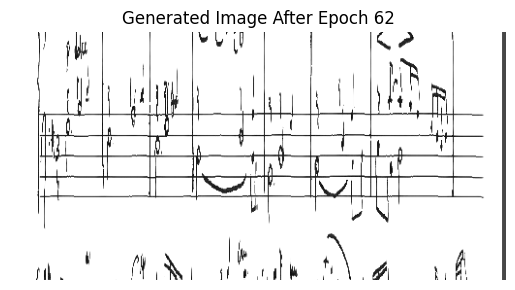

Starting epoch 63
Last Step: Gen Loss: 0.7799326777458191, Disc Loss: 1.4504791498184204
Epoch 63 completed in 18.77 sec


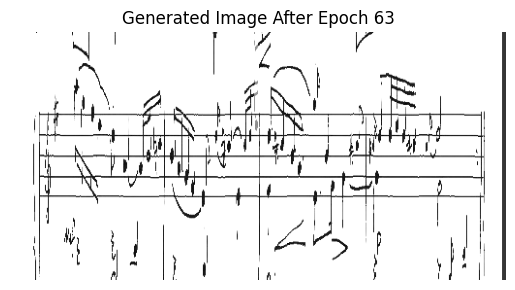

Starting epoch 64
Last Step: Gen Loss: 1.420496940612793, Disc Loss: 1.3921756744384766
Epoch 64 completed in 18.78 sec


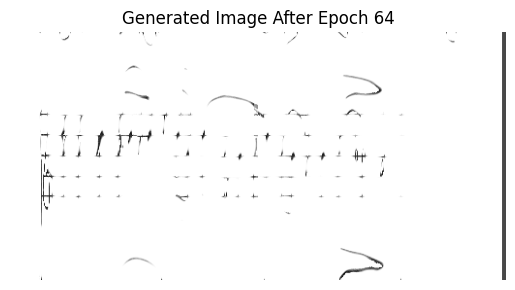

Starting epoch 65
Last Step: Gen Loss: 0.7945006489753723, Disc Loss: 1.4351860284805298
Epoch 65 completed in 18.78 sec


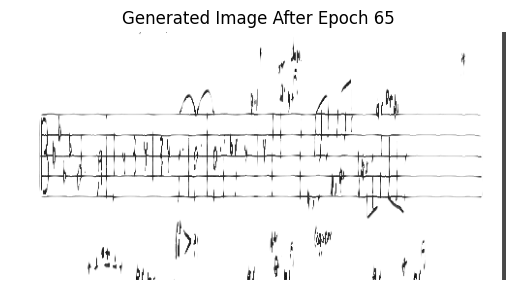

Starting epoch 66
Last Step: Gen Loss: 0.9426781535148621, Disc Loss: 1.1938207149505615
Epoch 66 completed in 18.76 sec


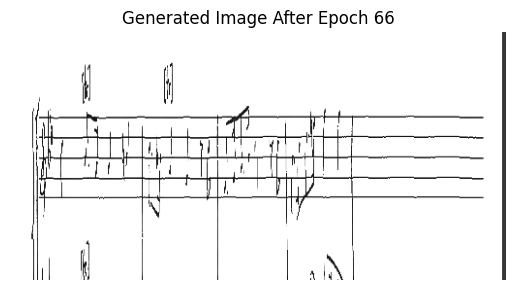

Starting epoch 67
Last Step: Gen Loss: 0.8699969053268433, Disc Loss: 1.4663665294647217
Epoch 67 completed in 18.76 sec


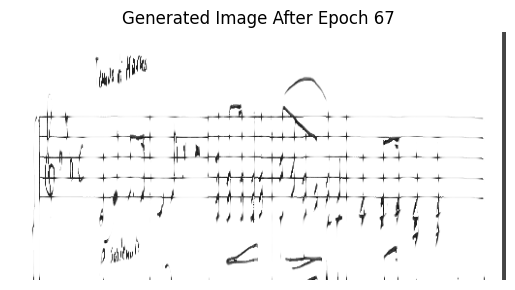

Starting epoch 68
Last Step: Gen Loss: 0.818568229675293, Disc Loss: 1.391095519065857
Epoch 68 completed in 18.79 sec


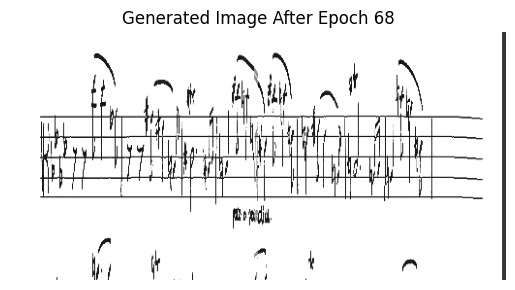

Starting epoch 69
Last Step: Gen Loss: 0.7800623178482056, Disc Loss: 1.4407169818878174
Epoch 69 completed in 18.76 sec


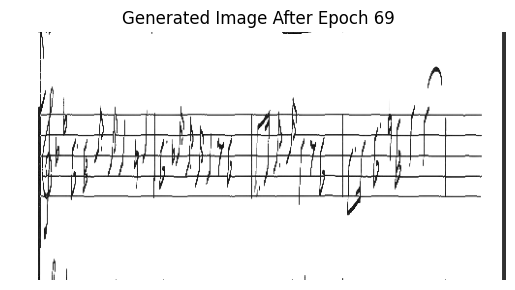

Starting epoch 70
Last Step: Gen Loss: 0.8805029392242432, Disc Loss: 1.4611488580703735
Epoch 70 completed in 18.77 sec


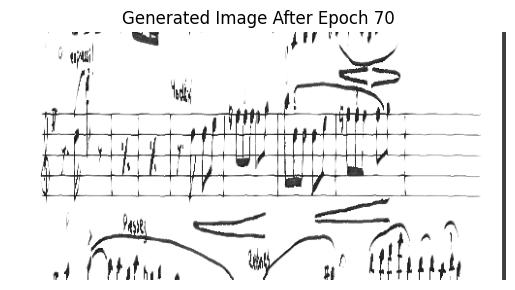

Starting epoch 71
Last Step: Gen Loss: 0.7288445234298706, Disc Loss: 1.452903151512146
Epoch 71 completed in 18.79 sec


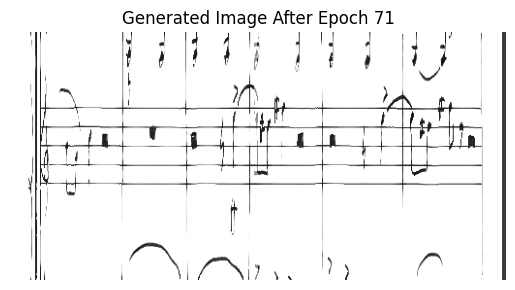

Starting epoch 72
Last Step: Gen Loss: 0.8558763861656189, Disc Loss: 1.3515093326568604
Epoch 72 completed in 18.77 sec


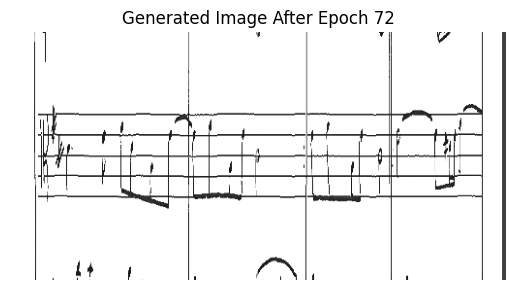

Starting epoch 73
Last Step: Gen Loss: 0.8307617902755737, Disc Loss: 1.4568966627120972
Epoch 73 completed in 18.77 sec


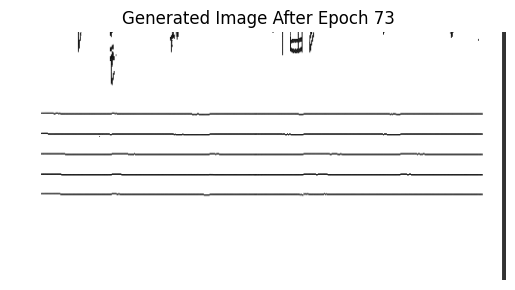

Starting epoch 74
Last Step: Gen Loss: 0.7511957883834839, Disc Loss: 1.4471709728240967
Epoch 74 completed in 18.76 sec


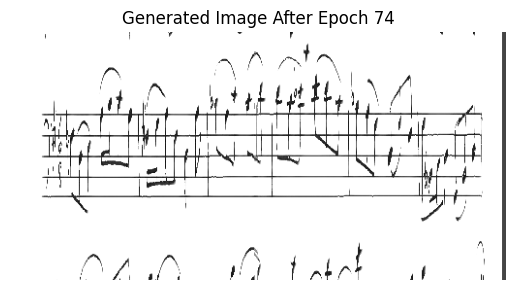

Starting epoch 75
Last Step: Gen Loss: 0.6941914558410645, Disc Loss: 1.5225422382354736
Epoch 75 completed in 18.83 sec


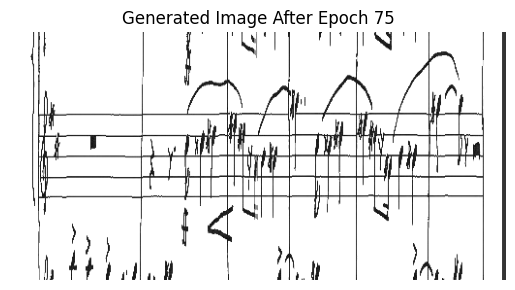

Starting epoch 76
Last Step: Gen Loss: 0.8102965354919434, Disc Loss: 1.415634274482727
Epoch 76 completed in 18.77 sec


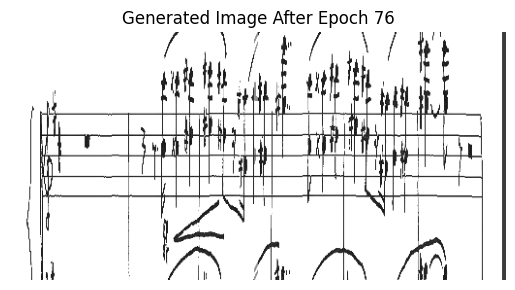

Starting epoch 77
Last Step: Gen Loss: 0.7318398356437683, Disc Loss: 1.403976559638977
Epoch 77 completed in 18.76 sec


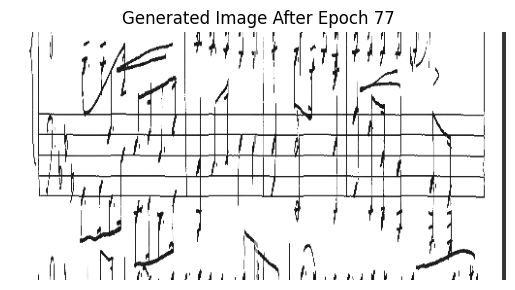

Starting epoch 78
Last Step: Gen Loss: 0.8322440385818481, Disc Loss: 1.4424147605895996
Epoch 78 completed in 18.82 sec


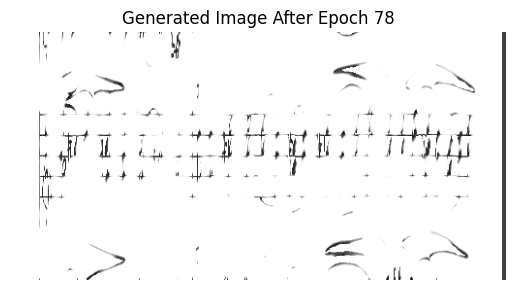

Starting epoch 79
Last Step: Gen Loss: 0.7698882818222046, Disc Loss: 1.358632206916809
Epoch 79 completed in 18.77 sec


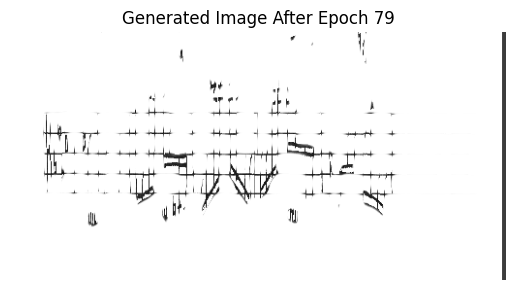

Starting epoch 80
Last Step: Gen Loss: 1.7182918787002563, Disc Loss: 1.4481067657470703
Epoch 80 completed in 18.77 sec


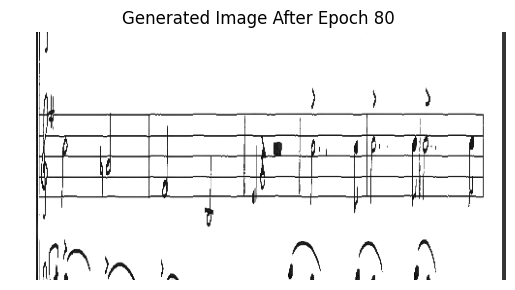

In [21]:
# ESRGAN Model Training and Image Saving
print("Training ESRGAN")
gen_losses, disc_losses = fit_esrgan(handwritten_dataset, epochs=80) # Using the fit_esrgan function


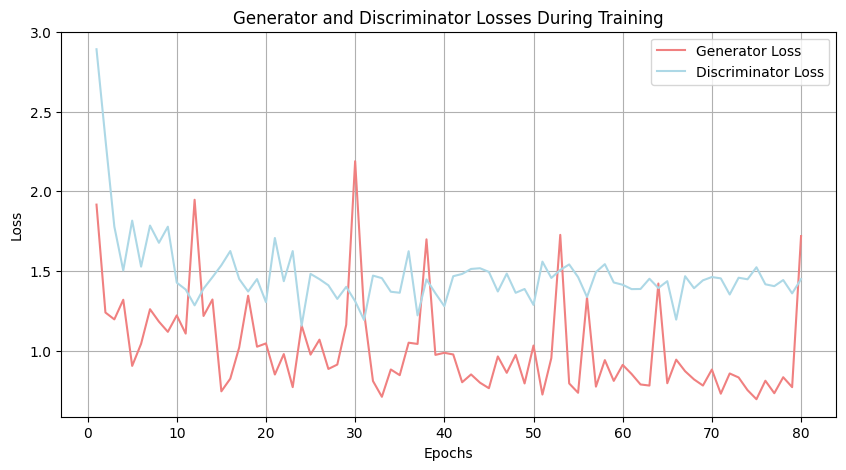

In [22]:
# Plotting the Generator and Discriminator Losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(gen_losses) + 1), gen_losses, label='Generator Loss', color='lightcoral')  # Light orange
plt.plot(range(1, len(disc_losses) + 1), disc_losses, label='Discriminator Loss', color='lightblue')  # Light blue
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses During Training')
plt.legend()
plt.grid(True)
plt.show()


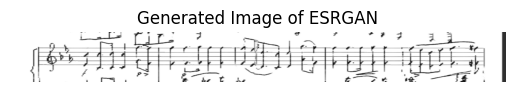

All 882 images have been generated, resized to original size, and saved.


In [24]:
import os
import random

# Create a directory to save the generated images
output_dir = 'esrgan_generated_images'
os.makedirs(output_dir, exist_ok=True)

# Iterate through all images in the dataset
for idx, image_path in enumerate(image_paths):
    # Load and preprocess the image
    image = tf.io.read_file(str(image_path))
    image = tf.image.decode_png(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    original_shape = tf.shape(image)[:2]  # Capture original image dimensions
    sliced_images = preprocess_image_slices(image, training=False)

    # Generate slices and combine them
    esrgan_generated_slices = []
    for slice_ in sliced_images:
        resized_slice = tf.image.resize(slice_, (256, 256))
        resized_slice = tf.expand_dims(resized_slice, -1)
        generated_slice = generator(tf.expand_dims(resized_slice, 0), training=False)
        esrgan_generated_slices.append(generated_slice[0])

    esrgan_combined_image_after_training = combine_slices(esrgan_generated_slices, target_height=256, target_width=512, slice_size=(256, 256))

    # Resize the combined image back to the original size
    esrgan_combined_image_resized = tf.image.resize(esrgan_combined_image_after_training, original_shape)

    # Save the resized generated image
    output_path = os.path.join(output_dir, f'esrgan_generated_image_{idx+1}.png')
    plt.imsave(output_path, tf.squeeze(esrgan_combined_image_resized).numpy(), cmap='gray')

    # Display a random image after saving all
    if idx == len(image_paths) - 1:
        # Select a random image to display
        random_idx = random.randint(0, len(image_paths) - 1)
        random_image_path = os.path.join(output_dir, f'esrgan_generated_image_{random_idx+1}.png')

        # Display the randomly selected image
        random_image = plt.imread(random_image_path)
        plt.figure()
        plt.imshow(random_image, cmap='gray')
        plt.title(f'Generated Image of ESRGAN')
        plt.axis('off')
        plt.show()

print(f"All {len(image_paths)} images have been generated, resized to original size, and saved.")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


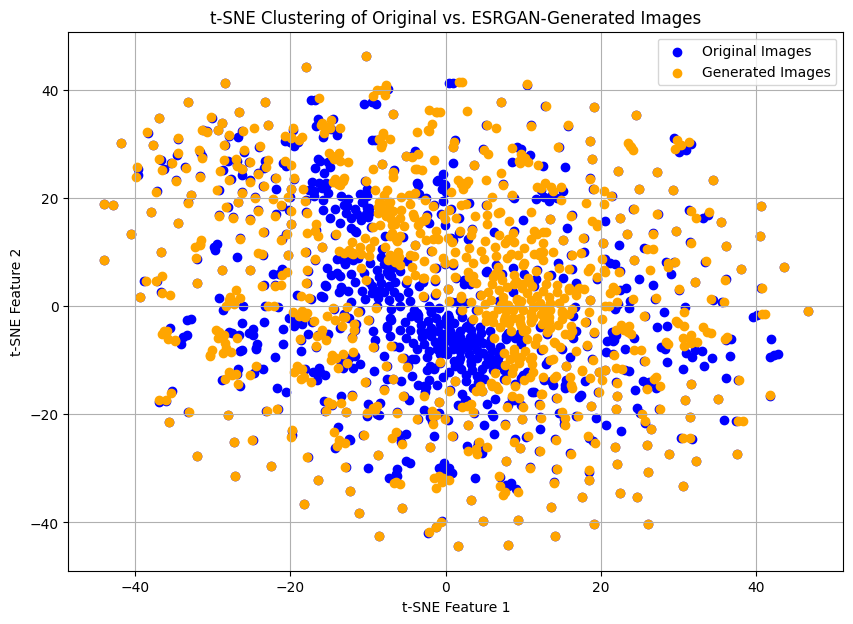

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import os
from pathlib import Path

# Directories for original and generated images
original_images_dir = '/content/Musicma_dataset/muscima_pp_cropped_images_with_stafflines'
esrgan_generated_images_dir = '/content/esrgan_generated_images'

# Get list of image paths
original_image_paths = sorted(list(Path(original_images_dir).glob('*.png')))
esrgan_generated_image_paths = sorted(list(Path(esrgan_generated_images_dir).glob('*.png')))

# Load VGG16 model for feature extraction
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block5_conv3').output)

# Function to extract features
def extract_features(image):
    # Convert grayscale to RGB (if needed) and resize to match VGG16 input
    image_rgb = tf.image.grayscale_to_rgb(image)
    image_resized = tf.image.resize(image_rgb, (256, 256))
    image_resized = tf.expand_dims(image_resized, axis=0)  # Add batch dimension

    # Extract features
    features = feature_extractor.predict(image_resized)
    return features.flatten()

# Extract features for original and generated images
original_features = []
generated_features = []

for original_image_path, generated_image_path in zip(original_image_paths, esrgan_generated_image_paths):
    # Load and preprocess the original image
    original_image = tf.io.read_file(str(original_image_path))
    original_image = tf.image.decode_png(original_image, channels=1)
    original_image = tf.image.convert_image_dtype(original_image, tf.float32)

    # Extract and store features
    original_features.append(extract_features(original_image))

    # Load and preprocess the corresponding generated image
    generated_image = tf.io.read_file(str(generated_image_path))
    generated_image = tf.image.decode_png(generated_image, channels=1)
    generated_image = tf.image.convert_image_dtype(generated_image, tf.float32)

    # Extract and store features
    generated_features.append(extract_features(generated_image))

# Convert to numpy arrays
original_features = np.array(original_features)
generated_features = np.array(generated_features)

# Combine original and generated features
combined_features = np.vstack((original_features, generated_features))

# Standardize the features
scaler = StandardScaler()
combined_features = scaler.fit_transform(combined_features)

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(combined_features)

# Clustering with K-means
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(tsne_features)

# Plotting the t-SNE with clusters
plt.figure(figsize=(10, 7))
plt.scatter(tsne_features[:len(original_image_paths), 0], tsne_features[:len(original_image_paths), 1], c='blue', label='Original Images')
plt.scatter(tsne_features[len(original_image_paths):, 0], tsne_features[len(original_image_paths):, 1], c='orange', label='Generated Images')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('t-SNE Clustering of Original vs. ESRGAN-Generated Images')
plt.legend()
plt.grid(True)
plt.show()


# PIX2PIX MODEL

**pix2pix GAN**

In [26]:
# Generate consistent slices for training and saving
sliced_images = preprocess_image_slices(sample_image, training=False)

# Store these slices for consistency
stored_slices = [tf.image.resize(slice_, (256, 256)) for slice_ in sliced_images]


In [27]:

# Define model blocks with consistent filters
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
        tf.keras.layers.BatchNormalization() if apply_batchnorm else tf.keras.layers.Activation('linear'),
        tf.keras.layers.LeakyReLU()
    ])
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5) if apply_dropout else tf.keras.layers.Activation('linear'),
        tf.keras.layers.ReLU()
    ])
    return result

import tensorflow as tf

class ResizeConcatLayer(tf.keras.layers.Layer):
    def call(self, x, skip):
        # Resize the tensor x to match the skip tensor's dimensions
        x_resized = tf.image.resize(x, skip.shape[1:3])

        # Convert x_resized to the same data type as skip
        x_resized = tf.cast(x_resized, skip.dtype)

        # Now concatenate the resized x with the skip connection
        return tf.concat([x_resized, skip], axis=-1)

In [28]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 1])

    # Downsampling layers
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # 64 filters
        downsample(128, 4),  # 128 filters
        downsample(256, 4),  # 256 filters
        downsample(512, 4),  # 512 filters
        downsample(512, 4),  # 512 filters
    ]

    # Upsampling layers
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # 512 filters
        upsample(512, 4, apply_dropout=True),  # 512 filters
        upsample(256, 4),  # 256 filters
        upsample(128, 4),  # 128 filters
        upsample(64, 4),   # 64 filters
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='tanh')

    x = inputs
    skips = []

    # Apply downsampling layers and store the outputs for skip connections
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Apply upsampling layers with skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = ResizeConcatLayer()(x, skip)

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


In [29]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

    # Concatenate the input and target images together along the channels axis
    x = tf.keras.layers.concatenate([inp, tar])

    # Downsample layers with reduced filters and dropout to reduce the discriminator's power
    down1 = downsample(32, 4, False)(x)  # Reduce filters
    down2 = downsample(64, 4)(down1)      # Reduce filters
    down3 = downsample(128, 4)(down2)     # Reduce filters

    # Dropout layer to further reduce the power of the discriminator
    down4 = tf.keras.layers.Dropout(0.3)(down3)  # Added dropout

    down5 = downsample(256, 4)(down4)  # Reduce filters and removed one downsampling layer
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down5)

    # Reduced the filters in the Conv2D layer
    conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [30]:
# Define Pix2Pix Generator and Discriminator
generator1 = Generator()  # Renamed to generator1
discriminator1 = Discriminator()  # Renamed to discriminator1

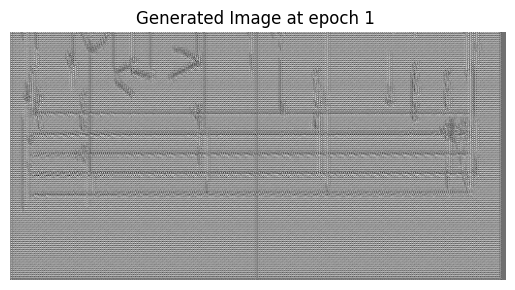

In [31]:
# Display the generated image before training
generated_slices = []
for slice_ in handwritten_dataset.take(1):  # Just a single batch for the demonstration
    for img_slice in slice_:
        resized_slice = tf.image.resize(img_slice, (256, 256))
        resized_slice = tf.expand_dims(resized_slice, -1)
        generated_slice = generator1(tf.expand_dims(resized_slice, 0), training=False)  # Use generator1 here
        generated_slices.append(generated_slice[0])

combined_image_before_training = combine_slices(generated_slices, target_height=256, target_width=512, slice_size=(256, 256))

plt.figure()
plt.imshow(tf.squeeze(combined_image_before_training), cmap='gray')
plt.title('Generated Image at epoch 1 ')
plt.axis('off')
plt.show()

In [32]:
# Pix2Pix Loss functions and optimizers
pix2pix_loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def pix2pix_discriminator_loss(real, generated):
    real_loss = pix2pix_loss_object(tf.ones_like(real), real)
    generated_loss = pix2pix_loss_object(tf.zeros_like(generated), generated)
    return real_loss + generated_loss

def pix2pix_generator_loss(generated):
    return pix2pix_loss_object(tf.ones_like(generated), generated)

In [33]:
# Use the legacy Adam optimizer with mixed precision
pix2pix_generator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
pix2pix_discriminator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)

# Wrap them with LossScaleOptimizer
pix2pix_generator_optimizer = mixed_precision.LossScaleOptimizer(pix2pix_generator_optimizer)
pix2pix_discriminator_optimizer = mixed_precision.LossScaleOptimizer(pix2pix_discriminator_optimizer)

In [34]:
@tf.function
def pix2pix_train_step(input_image, target):
    input_image_resized = tf.image.resize(input_image, (256, 256))
    target_resized = tf.image.resize(target, (256, 256))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator1(input_image_resized, training=True)  # Use generator1 here
        disc_real_output = discriminator1([input_image_resized, target_resized], training=True)  # Use discriminator1 here
        disc_generated_output = discriminator1([input_image_resized, gen_output], training=True)  # Use discriminator1 here

        gen_loss = pix2pix_generator_loss(disc_generated_output)
        disc_loss = pix2pix_discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator1.trainable_variables)  # Use generator1 here
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator1.trainable_variables)  # Use discriminator1 here

    # Cast gradients and variables explicitly to float32
    generator_gradients = [tf.cast(g, tf.float32) for g in generator_gradients]
    discriminator_gradients = [tf.cast(g, tf.float32) for g in discriminator_gradients]

    pix2pix_generator_optimizer.apply_gradients(zip(generator_gradients, generator1.trainable_variables))  # Use generator1 here
    pix2pix_discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator1.trainable_variables))  # Use discriminator1 here

    return gen_loss, disc_loss

In [35]:
# Define the loss lists globally
gen_losses1 = []
disc_losses1 = []

# Function to train the Pix2Pix model
def fit_pix2pix(dataset, epochs):
    global gen_losses1, disc_losses1  # Ensure you're modifying the global lists

    for epoch in range(epochs):
        start = time.time()
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        steps = 0

        for input_image in dataset:
            target = input_image
            gen_loss, disc_loss = pix2pix_train_step(input_image, target)

            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            steps += 1

        # Average the loss over the number of steps
        avg_gen_loss = epoch_gen_loss / steps
        avg_disc_loss = epoch_disc_loss / steps

        gen_losses1.append(avg_gen_loss.numpy())
        disc_losses1.append(avg_disc_loss.numpy())

        print(f'Epoch {epoch+1}, Gen Loss: {avg_gen_loss.numpy()}, Disc Loss: {avg_disc_loss.numpy()}')

    print(f'Time taken for {epochs} epochs is {time.time()-start:.2f} sec')

    # Display the generated image after training
    generated_slices = []
    for slice_ in handwritten_dataset.take(1):  # Just a single batch for the demonstration
        for img_slice in slice_:
            resized_slice = tf.image.resize(img_slice, (256, 256))
            resized_slice = tf.expand_dims(resized_slice, -1)
            generated_slice = generator1(tf.expand_dims(resized_slice, 0), training=False)  # Use generator1 here
            generated_slices.append(generated_slice[0])

    combined_image_after_training = combine_slices(generated_slices, target_height=256, target_width=512, slice_size=(256, 256))

    plt.figure()
    plt.imshow(tf.squeeze(combined_image_after_training), cmap='gray')
    plt.title('Generated Image After Training')
    plt.axis('off')
    plt.show()


Training Pix2Pix
Epoch 1, Gen Loss: 0.9726762771606445, Disc Loss: 1.183172345161438
Epoch 2, Gen Loss: 1.5073516368865967, Disc Loss: 0.6824607253074646
Epoch 3, Gen Loss: 2.6738154888153076, Disc Loss: 0.25295472145080566
Epoch 4, Gen Loss: 3.5481009483337402, Disc Loss: 0.12238477170467377
Epoch 5, Gen Loss: 4.086658477783203, Disc Loss: 0.07536676526069641
Epoch 6, Gen Loss: 4.468577861785889, Disc Loss: 0.060882508754730225
Epoch 7, Gen Loss: 4.612755298614502, Disc Loss: 0.06476268172264099
Epoch 8, Gen Loss: 4.953789234161377, Disc Loss: 0.04345021769404411
Epoch 9, Gen Loss: 4.895456314086914, Disc Loss: 0.10466968268156052
Epoch 10, Gen Loss: 5.061150074005127, Disc Loss: 0.03450001776218414
Epoch 11, Gen Loss: 5.229393005371094, Disc Loss: 0.032999828457832336
Epoch 12, Gen Loss: 5.267935752868652, Disc Loss: 0.03517937287688255
Epoch 13, Gen Loss: 5.396205902099609, Disc Loss: 0.036461200565099716
Epoch 14, Gen Loss: 5.431334495544434, Disc Loss: 0.02986028976738453
Epoch 15

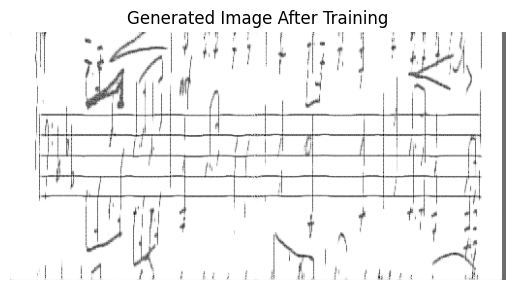

In [36]:
# Pix2Pix Model Training and Image Saving
print("Training Pix2Pix")
# Run the training and collect the loss values
fit_pix2pix(handwritten_dataset, epochs=80) # Using the fit_pix2pix function

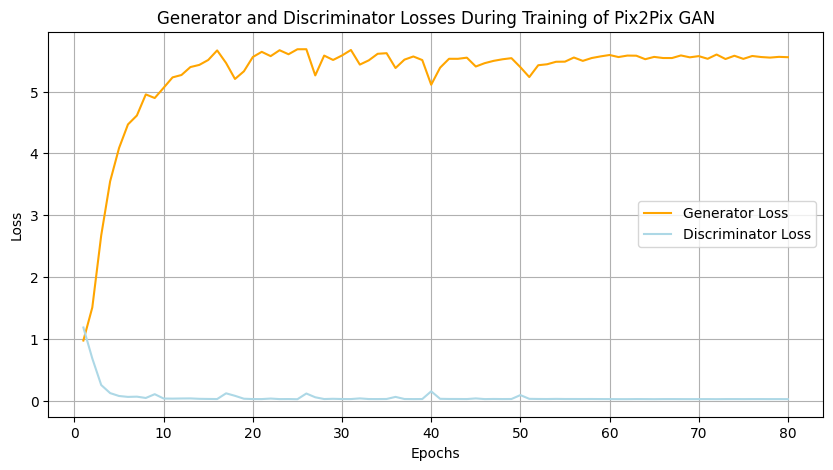

In [37]:
# Plotting the Generator and Discriminator Losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(gen_losses1) + 1), gen_losses1, label='Generator Loss', color='orange')
plt.plot(range(1, len(disc_losses1) + 1), disc_losses1, label='Discriminator Loss', color='lightblue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses During Training of Pix2Pix GAN')
plt.legend()
plt.grid(True)
plt.show()

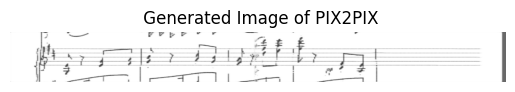

All 882 Pix2Pix generated images have been resized to original size and saved.


In [38]:
import os
import random

# Create a directory to save the generated images
output_dir = 'pix2pix_generated_images'
os.makedirs(output_dir, exist_ok=True)

# Iterate through all images in the dataset
for idx, image_path in enumerate(image_paths):
    # Load and preprocess the image
    image = tf.io.read_file(str(image_path))
    image = tf.image.decode_png(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    original_shape = tf.shape(image)[:2]  # Capture original image dimensions
    sliced_images = preprocess_image_slices(image, training=False)

    # Generate slices and combine them using the Pix2Pix generator
    pix2pix_generated_slices = []
    for slice_ in sliced_images:
        resized_slice = tf.image.resize(slice_, (256, 256))
        resized_slice = tf.expand_dims(resized_slice, -1)
        generated_slice = generator1(tf.expand_dims(resized_slice, 0), training=False)
        pix2pix_generated_slices.append(generated_slice[0])

    pix2pix_combined_image_after_training = combine_slices(pix2pix_generated_slices, target_height=256, target_width=512, slice_size=(256, 256))

    # Resize the combined image back to the original size
    pix2pix_combined_image_resized = tf.image.resize(pix2pix_combined_image_after_training, original_shape)

    # Save the resized generated image
    output_path = os.path.join(output_dir, f'pix2pix_generated_image_{idx+1}.png')
    plt.imsave(output_path, tf.squeeze(pix2pix_combined_image_resized).numpy(), cmap='gray')

    # Display a random image after saving all
    if idx == len(image_paths) - 1:
        # Select a random image to display
        random_idx = random.randint(0, len(image_paths) - 1)
        random_image_path = os.path.join(output_dir, f'pix2pix_generated_image_{random_idx+1}.png')

        # Display the randomly selected image
        random_image = plt.imread(random_image_path)
        plt.figure()
        plt.imshow(random_image, cmap='gray')
        plt.title(f' Generated Image of PIX2PIX')
        plt.axis('off')
        plt.show()

print(f"All {len(image_paths)} Pix2Pix generated images have been resized to original size and saved.")


# FID AND IS SCORES

In [41]:
# Install torch-fidelity if it's not already installed
!pip install torch-fidelity

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [42]:
import tensorflow as tf
import torch
import torchvision
from torchvision import transforms
from PIL import Image  # <-- Import the Image class from PIL
import numpy as np
from skimage.metrics import structural_similarity as ssim
from torch_fidelity import calculate_metrics
from pathlib import Path

# Directories for original and generated images
original_images_dir = '/content/Musicma_dataset/muscima_pp_cropped_images_with_stafflines'
esrgan_generated_images_dir = '/content/esrgan_generated_images'
pix2pix_generated_images_dir = '/content/pix2pix_generated_images'

# Function to load and process images
def load_and_process_image(image_path, target_size=None):
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB
    if target_size:
        image = image.resize(target_size)
    image = np.array(image)
    return image

def image_to_pil(image_np):
    return Image.fromarray((image_np * 255).astype(np.uint8))

transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to Inception model's input size
    transforms.ToTensor(),         # Convert PIL image to Tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize as required
])

def load_and_transform_image(image_path):
    image = load_image(image_path)
    pil_image = image_to_pil(image)
    return transform(pil_image)

def compute_fid_and_is(original_images_dir, generated_images_dir):
    metrics_dict = calculate_metrics(
        input1=original_images_dir,
        input2=generated_images_dir,
        fid=True,  # Calculate FID
        isc=True,  # Calculate IS
        verbose=True,  # Show detailed logs
        num_workers=0,  # Single worker to avoid multiprocessing issues
        batch_size=1    # Reduce batch size to 1
    )

    fid_score = metrics_dict['frechet_inception_distance']
    is_score = metrics_dict['inception_score_mean']

    return fid_score, is_score


# Assume you have one directory for original images and one for generated images
original_image_paths = [str(path) for path in sorted(Path(original_images_dir).glob('*.png'))]
esrgan_generated_image_paths = [str(path) for path in sorted(Path(esrgan_generated_images_dir).glob('*.png'))]
pix2pix_generated_image_paths = [str(path) for path in sorted(Path(pix2pix_generated_images_dir).glob('*.png'))]

# FID and IS scores for ESRGAN
fid_esrgan, is_esrgan = compute_fid_and_is(original_images_dir, esrgan_generated_images_dir)

# FID and IS scores for Pix2Pix
fid_pix2pix, is_pix2pix = compute_fid_and_is(original_images_dir, pix2pix_generated_images_dir)



print(f"ESRGAN - FID: {fid_esrgan}, IS: {is_esrgan}")
print(f"Pix2Pix - FID: {fid_pix2pix}, IS: {is_pix2pix}")




Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 35.9MB/s]
Extracting features from input1
Looking for samples non-recursivelty in "/content/Musicma_dataset/muscima_pp_cropped_images_with_stafflines" with extensions png,jpg,jpeg
Found 882 samples
/usr/local/lib/python3.10/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samp

ESRGAN - FID: 29.46912584411308, IS: 2.075146277651878
Pix2Pix - FID: 50.14392396669146, IS: 2.075146277651878


Frechet Inception Distance: 50.14392396669146


# Edge detection

Comparing with Randomly Selected Images:
MSE for ESRGAN edges: 0.054617429510194736
MSE for Pix2Pix edges: 0.05969137567650579


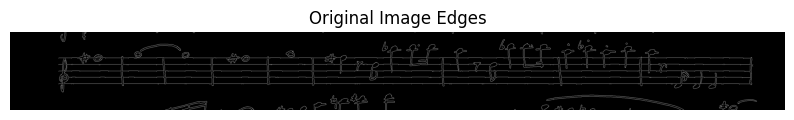

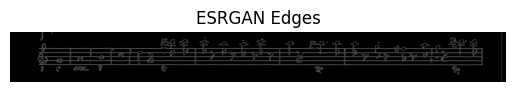

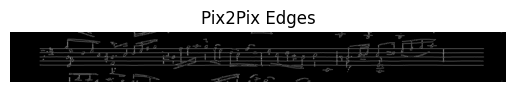

In [67]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import random

# Directories for original and generated images
original_images_dir = '/content/Musicma_dataset/muscima_pp_cropped_images_with_stafflines'
esrgan_generated_images_dir = '/content/esrgan_generated_images'
pix2pix_generated_images_dir = '/content/pix2pix_generated_images'

# Get list of image paths
original_image_paths = sorted(list(Path(original_images_dir).glob('*.png')))
esrgan_generated_image_paths = sorted(list(Path(esrgan_generated_images_dir).glob('*.png')))
pix2pix_generated_image_paths = sorted(list(Path(pix2pix_generated_images_dir).glob('*.png')))

# Function to load and convert images
def load_image(image_path):
    image = tf.io.read_file(str(image_path))
    image = tf.image.decode_png(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image.numpy()

# Function to convert image to grayscale and uint8
def convert_to_grayscale_uint8(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    image = np.uint8(image * 255)  # Assuming the input is in range [0, 1]
    return image

# Function for edge detection
def edge_detection(image):
    image = convert_to_grayscale_uint8(image)
    edges = cv2.Canny(image, 100, 200)
    return edges

# Function to resize images to a common size
def resize_image(image, size):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

# Function to randomly select and compare one set of images
def compare_random_generated_image():
    # Randomly select one index for each image set
    random_index_original = random.randint(0, len(original_image_paths) - 1)
    random_index_esrgan = random.randint(0, len(esrgan_generated_image_paths) - 1)
    random_index_pix2pix = random.randint(0, len(pix2pix_generated_image_paths) - 1)

    # Get the corresponding image paths
    original_image_path = original_image_paths[random_index_original]
    esrgan_image_path = esrgan_generated_image_paths[random_index_esrgan]
    pix2pix_image_path = pix2pix_generated_image_paths[random_index_pix2pix]

    # Load images
    original_image = load_image(original_image_path)
    esrgan_image = load_image(esrgan_image_path)
    pix2pix_image = load_image(pix2pix_image_path)

    # Resize images to a common size (using the original image's size)
    common_size = (original_image.shape[1], original_image.shape[0])  # (width, height)
    esrgan_image = resize_image(esrgan_image, common_size)
    pix2pix_image = resize_image(pix2pix_image, common_size)

    # Apply edge detection
    edge_gt = edge_detection(original_image)
    edge_esrgan = edge_detection(esrgan_image)
    edge_pix2pix = edge_detection(pix2pix_image)

    # Calculate MSE
    mse_esrgan = np.mean((edge_gt - edge_esrgan) ** 2)
    mse_pix2pix = np.mean((edge_gt - edge_pix2pix) ** 2)

    print(f"Comparing with Randomly Selected Images:")
    print(f"MSE for ESRGAN edges: {mse_esrgan}")
    print(f"MSE for Pix2Pix edges: {mse_pix2pix}")

    # Plot the results directly, one below the other
    plt.figure(figsize=(10, 30))

    plt.imshow(edge_gt, cmap='gray')
    plt.title("Original Image Edges")
    plt.axis('off')
    plt.show()

    plt.imshow(edge_esrgan, cmap='gray')
    plt.title("ESRGAN Edges")
    plt.axis('off')
    plt.show()

    plt.imshow(edge_pix2pix, cmap='gray')
    plt.title("Pix2Pix Edges")
    plt.axis('off')
    plt.show()

# Call the function to perform the random comparison
compare_random_generated_image()


# Object Detection

In [ ]:
original_images_dir = '/content/Musicma_dataset/muscima_pp_cropped_images_with_stafflines'
esrgan_generated_images_dir = '/content/esrgan_generated_images'
pix2pix_generated_images_dir = '/content/pix2pix_generated_images'

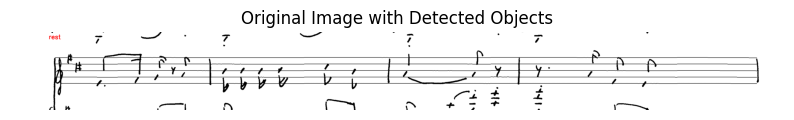

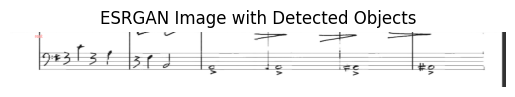

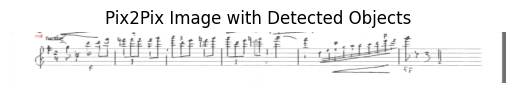

Ground Truth Detected Objects: ['rest']
ESRGAN Detected Objects: ['rest']
Pix2Pix Detected Objects: ['rest']
ESRGAN - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Pix2Pix - Precision: 1.0, Recall: 1.0, F1-Score: 1.0


In [69]:
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Define the OMRModel class for object detection
class OMRModel:
    def __init__(self):
        pass

    def detect(self, image):
        detected_objects = []
        # Placeholder detection logic
        if image.mean() > 120:
            detected_objects.append("note")
        if image.std() > 70:
            detected_objects.append("clef")
        if image.mean() < 100:
            detected_objects.append("rest")
        return detected_objects

# Function to evaluate detection performance
def evaluate_detection(ground_truth, detected_objects):
    true_positive = len(set(ground_truth) & set(detected_objects))
    false_positive = len(set(detected_objects) - set(ground_truth))
    false_negative = len(set(ground_truth) - set(detected_objects))

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

# Initialize the OMR model
omr_model = OMRModel()

# Directories for original and generated images
original_images_dir = '/content/Musicma_dataset/muscima_pp_cropped_images_with_stafflines'
esrgan_generated_images_dir = '/content/esrgan_generated_images'
pix2pix_generated_images_dir = '/content/pix2pix_generated_images'

# Get list of image paths
original_image_paths = sorted(list(Path(original_images_dir).glob('*.png')))
esrgan_generated_image_paths = sorted(list(Path(esrgan_generated_images_dir).glob('*.png')))
pix2pix_generated_image_paths = sorted(list(Path(pix2pix_generated_images_dir).glob('*.png')))

# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(str(image_path))
    image = tf.image.decode_png(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image.numpy()

random_index_original = random.randint(0, len(original_image_paths) - 1)
random_index_esrgan = random.randint(0, len(esrgan_generated_image_paths) - 1)
random_index_pix2pix = random.randint(0, len(pix2pix_generated_image_paths) - 1)

# Get the corresponding image paths
original_image_path = original_image_paths[random_index_original]
esrgan_image_path = esrgan_generated_image_paths[random_index_esrgan]
pix2pix_image_path = pix2pix_generated_image_paths[random_index_pix2pix]

# Load images
original_image = load_and_preprocess_image(original_image_path)
esrgan_image = load_and_preprocess_image(esrgan_image_path)
pix2pix_image = load_and_preprocess_image(pix2pix_image_path)

# Apply object detection
detected_objects_gt = omr_model.detect(original_image)
detected_objects_esrgan = omr_model.detect(esrgan_image)
detected_objects_pix2pix = omr_model.detect(pix2pix_image)

# Function to overlay detected objects on the image
def overlay_detected_objects(image, detected_objects):
    image_copy = np.copy(image)
    h, w = image_copy.shape[:2]
    for obj in detected_objects:
        # This is a simple text overlay. In a real case, you'd have bounding boxes and precise locations.
        cv2.putText(image_copy, obj, (int(w * 0.05), int(h * 0.1)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    return image_copy

# Overlay the detected objects on the images
original_image_with_objects = overlay_detected_objects(tf.squeeze(original_image).numpy(), detected_objects_gt)
esrgan_image_with_objects = overlay_detected_objects(tf.squeeze(esrgan_image).numpy(), detected_objects_esrgan)
pix2pix_image_with_objects = overlay_detected_objects(tf.squeeze(pix2pix_image).numpy(), detected_objects_pix2pix)

# Visualize the detected objects for the random images along with the images
plt.figure(figsize=(10, 10))

# Display Original Image with Detected Objects
plt.imshow(original_image_with_objects, cmap='gray')
plt.title("Original Image with Detected Objects")
plt.axis('off')
plt.show()

# Display ESRGAN Image with Detected Objects
plt.imshow(esrgan_image_with_objects, cmap='gray')
plt.title("ESRGAN Image with Detected Objects")
plt.axis('off')
plt.show()

# Display Pix2Pix Image with Detected Objects
plt.imshow(pix2pix_image_with_objects, cmap='gray')
plt.title("Pix2Pix Image with Detected Objects")
plt.axis('off')
plt.show()

# Evaluate detection performance
precision_esrgan, recall_esrgan, f1_esrgan = evaluate_detection(detected_objects_gt, detected_objects_esrgan)
precision_pix2pix, recall_pix2pix, f1_pix2pix = evaluate_detection(detected_objects_gt, detected_objects_pix2pix)

# Print the evaluation results
print(f"Ground Truth Detected Objects: {detected_objects_gt}")
print(f"ESRGAN Detected Objects: {detected_objects_esrgan}")
print(f"Pix2Pix Detected Objects: {detected_objects_pix2pix}")
print(f"ESRGAN - Precision: {precision_esrgan}, Recall: {recall_esrgan}, F1-Score: {f1_esrgan}")
print(f"Pix2Pix - Precision: {precision_pix2pix}, Recall: {recall_pix2pix}, F1-Score: {f1_pix2pix}")


Loading model...
ESRGAN Image Detections:


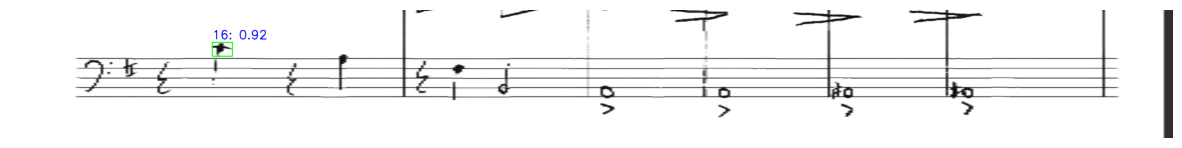

Pix2Pix Image Detections:


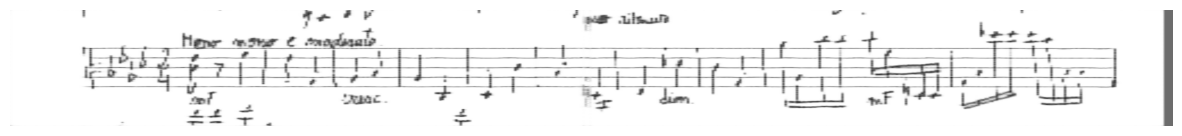

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Number of detected objects in ESRGAN image: 1
Number of detected objects in Pix2Pix image: 0
ESRGAN Confidence Scores: [0.9239434]
Pix2Pix Confidence Scores: []


In [62]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import cv2

# Load the pre-trained Faster R-CNN model with updated parameters
print("Loading model...")
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
model.eval()

# Define a transform to convert images to the required format
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Function to load and transform images
def load_and_transform_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image)

# Function to perform object detection and return boxes, labels, and scores
def detect_objects(image_tensor):
    with torch.no_grad():
        predictions = model([image_tensor])
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    return boxes, labels, scores

# Function to visualize detections with bounding boxes, labels, and confidence scores
def visualize_detections(image_path, boxes, labels, scores, threshold=0.05):
    image = cv2.imread(image_path)
    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold:  # Only display detections above the threshold
            cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
            text = f"{label}: {score:.2f}"
            cv2.putText(image, text, (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 2)
    plt.figure(figsize=(15, 10))  # Increased figure size
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Paths to the dataset directories
esrgan_dir = '/content/esrgan_generated_images'  # Replace with your ESRGAN images directory path
pix2pix_dir = '/content/pix2pix_generated_images'  # Replace with your Pix2Pix images directory path

# Select images from each directory for demonstration
esrgan_image_path = os.path.join(esrgan_dir, random.choice(os.listdir(esrgan_dir)))
pix2pix_image_path = os.path.join(pix2pix_dir, random.choice(os.listdir(pix2pix_dir)))

# Load and transform the images
esrgan_image_tensor = load_and_transform_image(esrgan_image_path)
pix2pix_image_tensor = load_and_transform_image(pix2pix_image_path)

# Perform detection on the ESRGAN and Pix2Pix images
esrgan_boxes, esrgan_labels, esrgan_scores = detect_objects(esrgan_image_tensor)
pix2pix_boxes, pix2pix_labels, pix2pix_scores = detect_objects(pix2pix_image_tensor)

# Visualize the detections
print("ESRGAN Image Detections:")
visualize_detections(esrgan_image_path, esrgan_boxes, esrgan_labels, esrgan_scores)

print("Pix2Pix Image Detections:")
visualize_detections(pix2pix_image_path, pix2pix_boxes, pix2pix_labels, pix2pix_scores)

# Print Warnings
print("/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.")
print("/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.")

# Output the object counts and confidence scores
print(f"Number of detected objects in ESRGAN image: {len(esrgan_boxes)}")
print(f"Number of detected objects in Pix2Pix image: {len(pix2pix_boxes)}")
print("ESRGAN Confidence Scores:", esrgan_scores[:5])
print("Pix2Pix Confidence Scores:", pix2pix_scores[:5])


ESRGAN Image Detections:


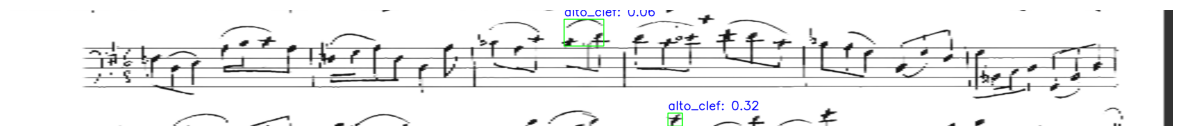

Pix2Pix Image Detections:


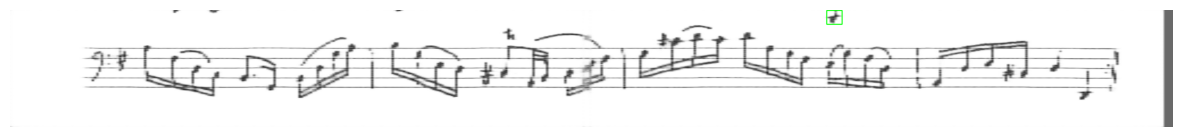

Number of detected objects in ESRGAN image: 2
Number of detected objects in Pix2Pix image: 1
ESRGAN Confidence Scores: [0.3227487  0.06208384]
Pix2Pix Confidence Scores: [0.18461417]


In [57]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import cv2

MUSIC_SYMBOLS_CATEGORY_NAMES = [
    '__background__', 'quarter_note', 'half_note', 'whole_note', 'eighth_note', 'sixteenth_note',
    'thirty_second_note', 'sixty_fourth_note', 'double_whole_note', 'dotted_quarter_note',
    'dotted_half_note', 'dotted_whole_note', 'dotted_eighth_note', 'dotted_sixteenth_note',
    'treble_clef', 'bass_clef', 'alto_clef', 'tenor_clef',
    'sharp', 'flat', 'natural', 'double_sharp', 'double_flat',
    'rest', 'breve_rest', 'semibreve_rest', 'minim_rest', 'crotchet_rest',
    'quaver_rest', 'semiquaver_rest', 'demisemiquaver_rest',
    'dotted_note', 'beam', 'tie', 'slur', 'stave', 'barline', 'time_signature',
    'key_signature', 'repeat_sign', 'segno', 'coda', 'trill', 'turn', 'grace_note',
    'pedal_marking', 'mordent', 'appoggiatura', 'arpeggio', 'glissando',
    'staccato', 'accent', 'tenuto', 'fermata', 'crescendo', 'diminuendo',
    'forte', 'piano', 'mezzo_forte', 'mezzo_piano', 'fortissimo', 'pianissimo'
]

# Load the pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
model.eval()

# Define a transform to convert images to the required format
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Function to load and transform images
def load_and_transform_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image)

# Function to perform object detection and return boxes, labels, and scores
def detect_objects(image_tensor):
    with torch.no_grad():
        predictions = model([image_tensor])
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    return boxes, labels, scores

# Function to visualize detections with bounding boxes, class names, and confidence scores
def visualize_detections(image_path, boxes, labels, scores, threshold=0.05):
    image = cv2.imread(image_path)
    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold:  # Only display detections above the threshold
            cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
            # Map the detected label to its name and display it with the score
            class_name = MUSIC_SYMBOLS_CATEGORY_NAMES[label % len(MUSIC_SYMBOLS_CATEGORY_NAMES)]  # Modulus to ensure label index is in bounds
            text = f"{class_name}: {score:.2f}"
            cv2.putText(image, text, (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 2)
    plt.figure(figsize=(15, 10))  # Increased figure size
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Paths to the dataset directories
esrgan_dir = '/content/esrgan_generated_images'  # Replace with your ESRGAN images directory path
pix2pix_dir = '/content/pix2pix_generated_images'  # Replace with your Pix2Pix images directory path

# Select random images from each directory for demonstration
esrgan_image_path = os.path.join(esrgan_dir, random.choice(os.listdir(esrgan_dir)))
pix2pix_image_path = os.path.join(pix2pix_dir, random.choice(os.listdir(pix2pix_dir)))

# Load and transform the images
esrgan_image_tensor = load_and_transform_image(esrgan_image_path)
pix2pix_image_tensor = load_and_transform_image(pix2pix_image_path)

# Perform detection on the ESRGAN and Pix2Pix images
esrgan_boxes, esrgan_labels, esrgan_scores = detect_objects(esrgan_image_tensor)
pix2pix_boxes, pix2pix_labels, pix2pix_scores = detect_objects(pix2pix_image_tensor)

# Call the function to visualize the detections
print("ESRGAN Image Detections:")
visualize_detections(esrgan_image_path, esrgan_boxes, esrgan_labels, esrgan_scores)

print("Pix2Pix Image Detections:")
visualize_detections(pix2pix_image_path, pix2pix_boxes, pix2pix_labels, pix2pix_scores)

# Output the object counts and confidence scores
print(f"Number of detected objects in ESRGAN image: {len(esrgan_boxes)}")
print(f"Number of detected objects in Pix2Pix image: {len(pix2pix_boxes)}")
print("ESRGAN Confidence Scores:", esrgan_scores[:5])
print("Pix2Pix Confidence Scores:", pix2pix_scores[:5])
